In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 3)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 300
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-11-11 16:05:21.215635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 16:05:21.232935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 16:05:21.253029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 16:05:21.259178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 16:05:21.275031: I tensorflow/core/platform/cpu_feature_guar

Training set size: 240
Test set size: 60
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [7]:
X_train.shape

(240, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [10]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [13]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_sampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 100, 1: 100, 2: 100}


In [14]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [15]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([3, 1024])
Number of parameters: 3072
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([3])
Number of parameters: 3
--------------------------------------------------
Total number of trainable parameters: 5379


In [17]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([240, 64, 16])
Row sums: [58.107765 50.154633 58.232937 53.75739  55.83613  57.17717  58.589275
 56.712044 57.705383 58.229412 55.65634  58.65195  57.17113  56.865204
 49.077774 58.057434 50.349483 54.349625 43.715744 54.515728 57.034092
 54.974785 57.30323  57.190865 57.656914 58.172775 57.212624 52.86091
 53.476982 58.75654  43.14321  58.33634  57.368576 57.38564  54.985806
 57.492313 57.174156 55.968193 55.98204  56.85619  54.178993 57.41002
 55.433098 54.420593 55.556286 57.33915  58.436417 57.945854 56.197826
 57.998066 46.8088   47.80219  56.727898 55.61046  50.967957 58.2162
 54.61714  55.651016 55.950657 43.192657 50.50008  51.479523 58.601738
 55.99391 ]


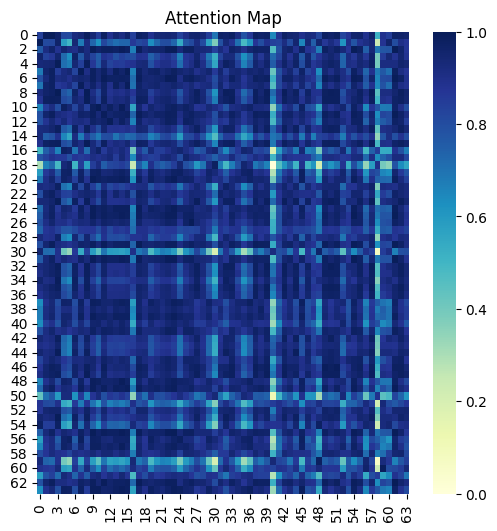

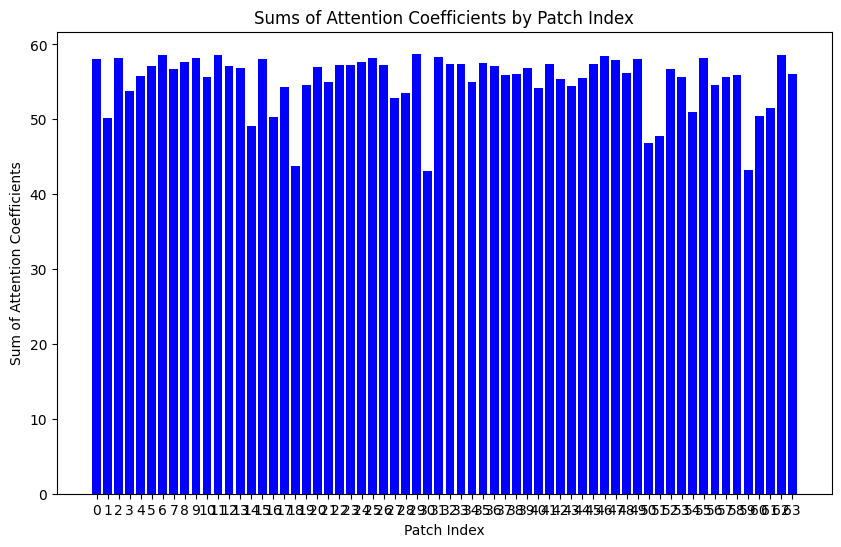

tensor([2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0,
        2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
        0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
        2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2,
        0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2,
        2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  1%|          | 1/100 [25:41<42:23:51, 1541.74s/it]

torch.Size([240, 64, 16])
Row sums: [57.97191  50.473595 58.118736 53.552784 55.724766 57.200996 58.57218
 56.95764  57.441895 58.252792 55.99068  58.708923 57.22095  57.10834
 49.232185 58.2034   49.88706  54.298424 43.193874 54.643337 57.158302
 54.74224  57.43272  57.375008 57.87767  58.193604 57.260086 53.14862
 53.490555 58.756847 42.584198 58.4848   57.14276  57.551945 55.27564
 57.726147 57.116943 55.83426  55.900036 56.598984 54.067623 57.467487
 55.625847 54.726334 55.325203 57.4402   58.372364 58.086533 56.58055
 58.095978 46.358242 47.155315 56.45066  55.950527 51.406517 58.187714
 54.43895  55.420967 55.8168   43.318455 50.043343 51.175705 58.667027
 55.822834]


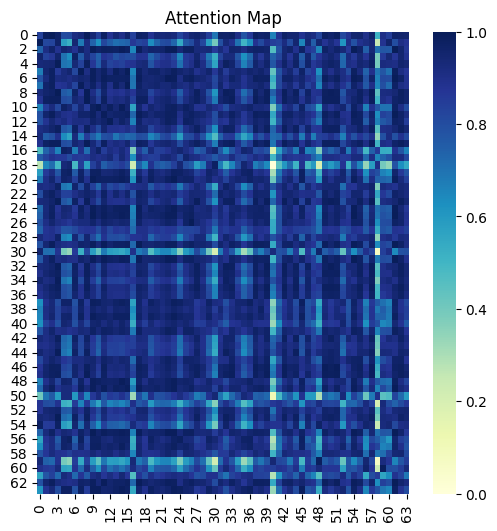

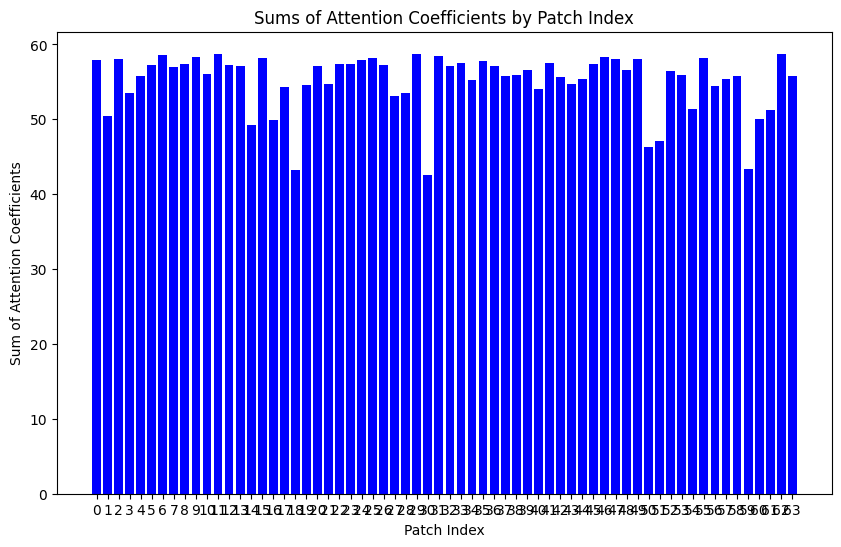

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  2%|▏         | 2/100 [54:27<44:54:34, 1649.74s/it]

torch.Size([240, 64, 16])
Row sums: [57.910904 51.026527 57.985672 53.924065 55.693653 57.293205 58.549534
 57.135105 57.44951  58.44059  55.855263 58.72513  57.21194  57.165405
 49.465836 58.378296 50.203026 54.48107  42.76224  54.71714  57.262955
 54.660835 57.496765 57.602577 57.7444   58.228363 57.31243  53.0645
 53.379448 58.724617 42.285686 58.430397 56.992153 57.750496 55.54654
 57.98699  57.241714 55.64919  55.78096  56.72856  53.93827  57.512573
 55.8834   55.088814 55.23644  57.576035 58.358566 58.299103 56.877617
 58.116116 45.94828  46.816017 56.27485  56.335518 51.971962 58.08271
 54.415184 55.17081  55.948322 43.884865 50.510067 50.831818 58.713715
 55.589825]


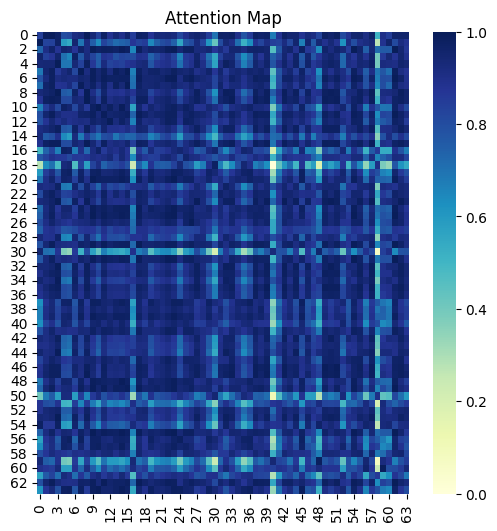

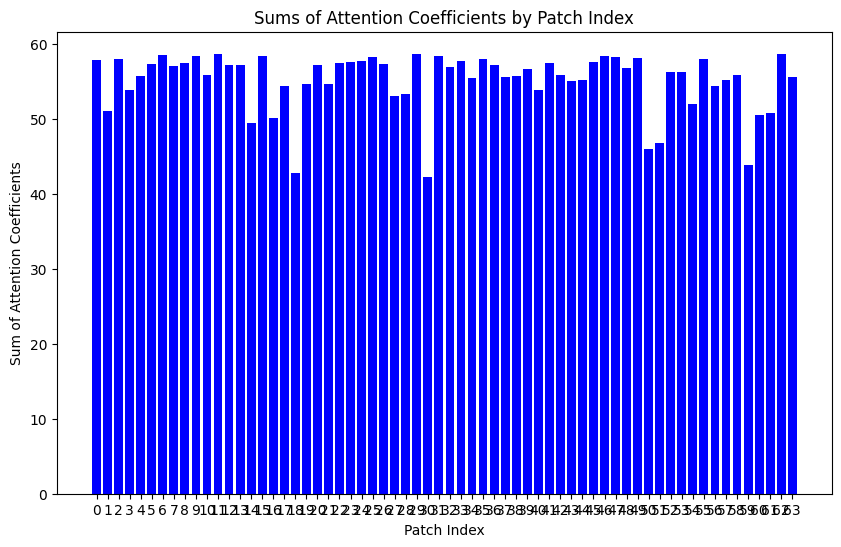

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  3%|▎         | 3/100 [1:22:22<44:46:14, 1661.59s/it]

torch.Size([240, 64, 16])
Row sums: [57.845932 51.636627 57.841732 54.402695 55.698982 57.32421  58.53961
 57.28401  57.45893  58.640965 55.647396 58.75006  57.19511  57.22936
 49.638664 58.572037 50.548424 54.693863 42.286743 54.754387 57.368702
 54.615295 57.566097 57.85652  57.56046  58.251144 57.373978 52.986107
 53.29914  58.673744 42.09968  58.355556 56.871925 57.966637 55.717392
 58.197647 57.415253 55.433563 55.63697  56.88202  53.809685 57.578102
 56.19667  55.473507 55.196518 57.70732  58.41218  58.511833 57.15702
 58.100822 45.52035  46.531727 56.11094  56.72995  52.609703 58.037556
 54.35601  54.897137 56.090763 44.577835 51.091293 50.45493  58.76031
 55.31136 ]


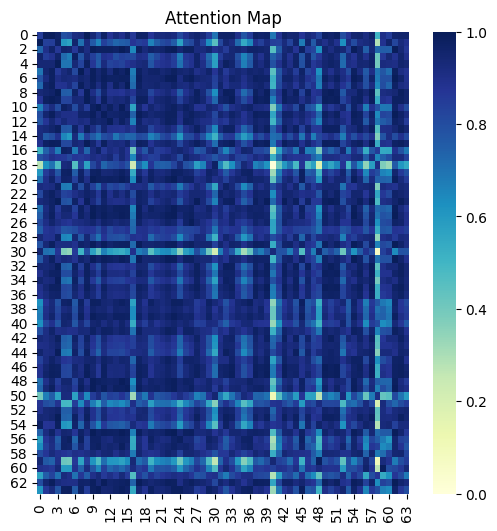

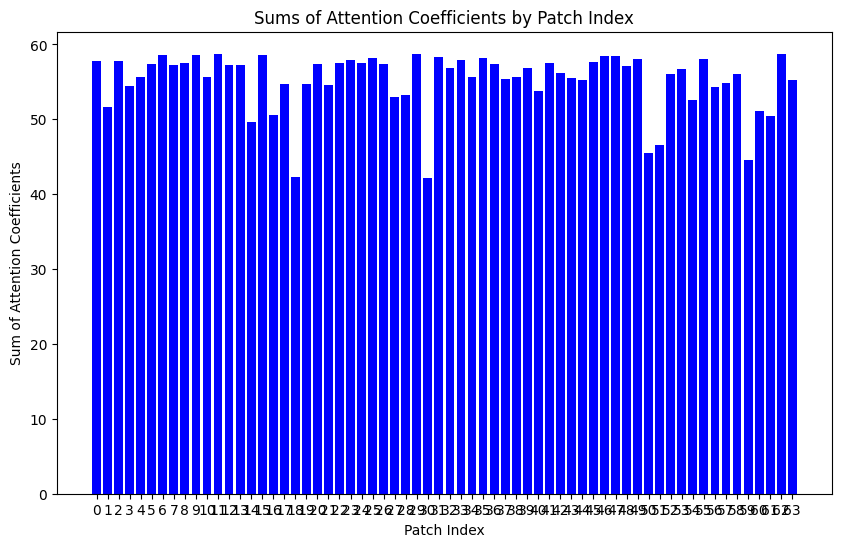

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  4%|▍         | 4/100 [1:50:11<44:22:50, 1664.28s/it]

torch.Size([240, 64, 16])
Row sums: [57.768284 52.2584   57.6589   54.90356  55.71277  57.3294   58.529564
 57.405785 57.41242  58.818367 55.38144  58.764183 57.15427  57.283897
 49.770348 58.75479  50.910103 54.913452 41.795834 54.72513  57.470566
 54.580093 57.63272  58.10215  57.32412  58.25215  57.43022  52.902695
 53.21334  58.591133 41.967613 58.24647  56.75764  58.17179  55.820198
 58.37585  57.589638 55.191635 55.466827 57.04133  53.67463  57.641945
 56.519196 55.842922 55.16656  57.820045 58.49093  58.699303 57.41369
 58.057808 45.081306 46.265583 55.941772 57.10828  53.249817 58.003677
 54.27233  54.58982  56.226192 45.315353 51.706944 50.044655 58.79596
 54.99711 ]


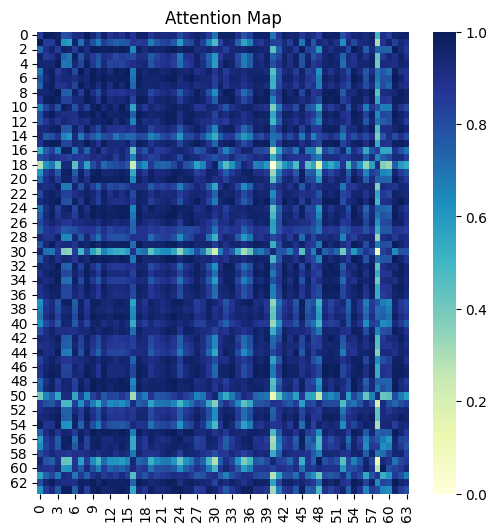

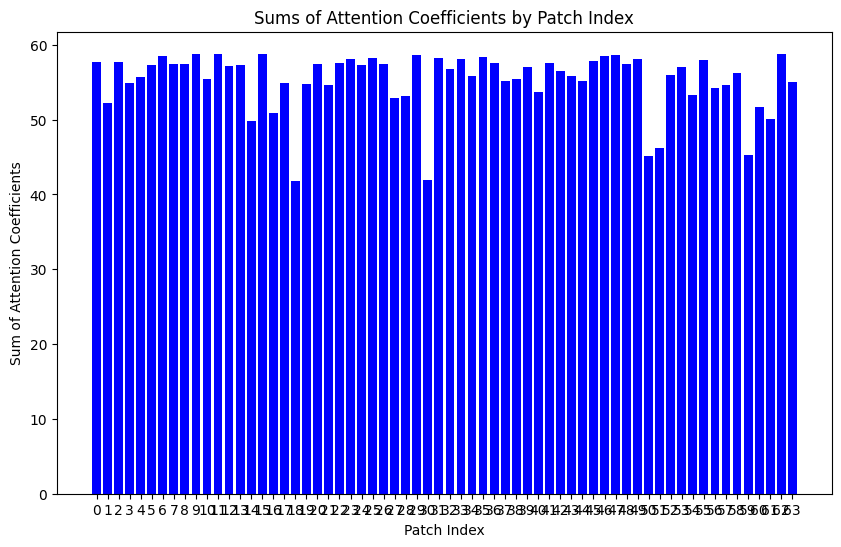

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  5%|▌         | 5/100 [2:22:07<46:19:15, 1755.33s/it]

torch.Size([240, 64, 16])
Row sums: [57.670372 52.857822 57.426384 55.38256  55.71659  57.363964 58.511826
 57.500988 57.314095 58.951927 55.06591  58.746033 57.08026  57.316402
 49.878815 58.908318 51.277454 55.125057 41.312378 54.64262  57.558582
 54.539314 57.689545 58.318924 57.03357  58.21889  57.469227 52.80198
 53.114285 58.46669  41.862514 58.100113 56.630028 58.347614 55.857635
 58.526493 57.739574 54.930855 55.269917 57.197052 53.52623  57.691105
 56.824577 56.176437 55.12419  57.90365  58.5512   58.84577  57.63197
 58.003853 44.650967 46.02945  55.759865 57.453796 53.85807  57.950893
 54.175865 54.247765 56.34294  46.062088 52.31794  49.608932 58.8151
 54.652946]


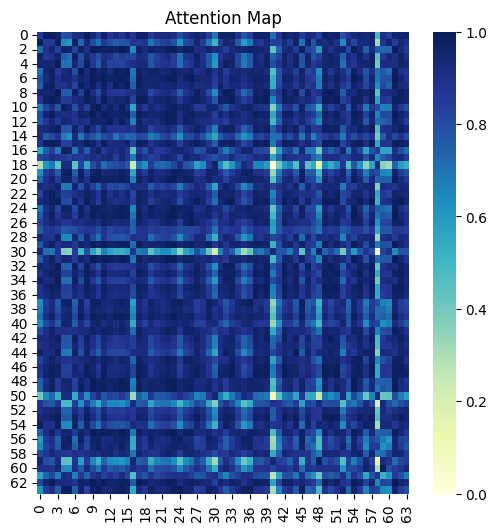

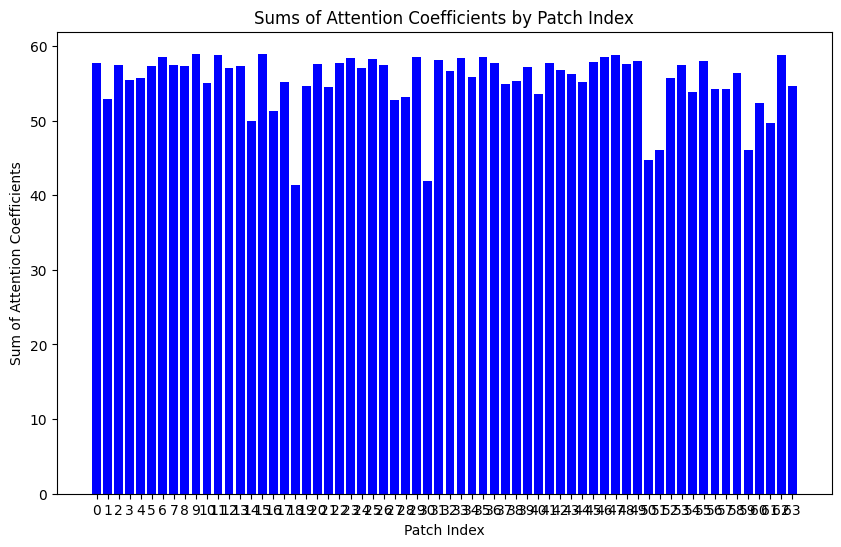

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  6%|▌         | 6/100 [2:51:09<45:42:44, 1750.68s/it]

torch.Size([240, 64, 16])
Row sums: [57.56037  53.40616  57.20898  55.82325  55.7043   57.409035 58.455284
 57.589756 57.229847 59.043663 54.73551  58.699303 56.98925  57.306915
 49.928947 59.033092 51.66633  55.329453 40.882584 54.501434 57.651627
 54.47844  57.725597 58.501118 56.73843  58.220333 57.49376  52.683743
 52.9982   58.343624 41.754494 57.93467  56.49273  58.492294 56.022545
 58.652805 57.865364 54.845314 55.07133  57.367065 53.35676  57.732998
 57.0895   56.4683   55.053276 57.984222 58.56318  58.94388  57.81747
 57.926502 44.244514 45.76303  55.557316 57.758133 54.413628 57.874123
 54.113853 53.909267 56.464325 46.769207 52.890842 49.177887 58.81837
 54.319843]


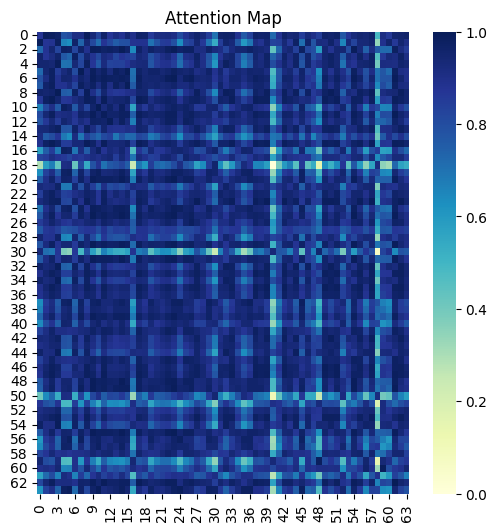

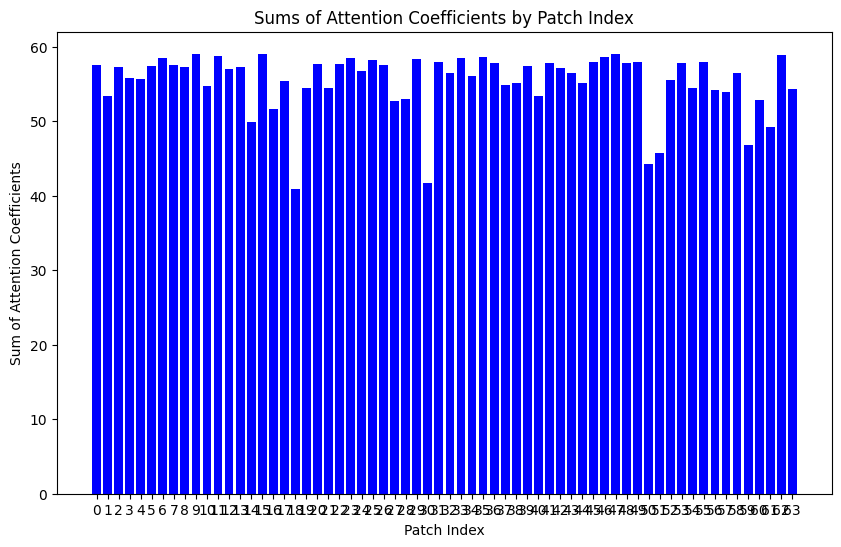

tensor([2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2,
        2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2,
        0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0,
        0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2,
        0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  7%|▋         | 7/100 [3:20:12<45:09:50, 1748.29s/it]

torch.Size([240, 64, 16])
Row sums: [57.51451  53.906044 57.166054 56.230034 55.68896  57.45781  58.434525
 57.715332 57.429337 59.1138   54.404854 58.682472 56.904972 57.302246
 49.992058 59.147415 52.085266 55.530838 40.573006 54.37953  57.775368
 54.418877 57.758114 58.667755 56.443127 58.282417 57.52082  52.580925
 52.89167  58.368835 41.64618  57.77144  56.34431  58.617508 56.11436
 58.761078 57.943947 54.801285 54.892235 57.563087 53.234688 57.75774
 57.311096 56.717934 54.958824 58.062847 58.560204 59.010273 57.980057
 57.85791  43.824314 45.467304 55.342968 58.02613  54.829266 57.78694
 54.083466 53.588463 56.613373 47.399773 53.389725 48.759182 58.84733
 54.101063]


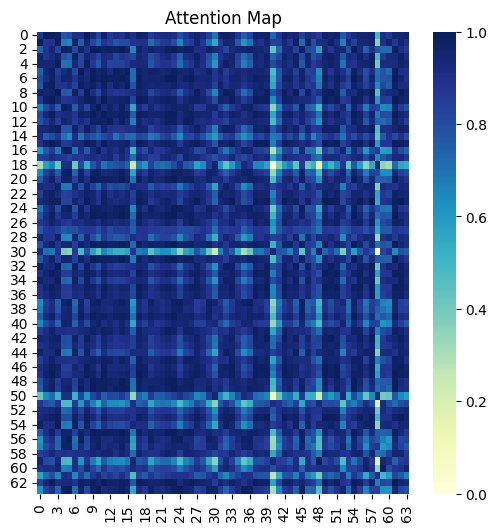

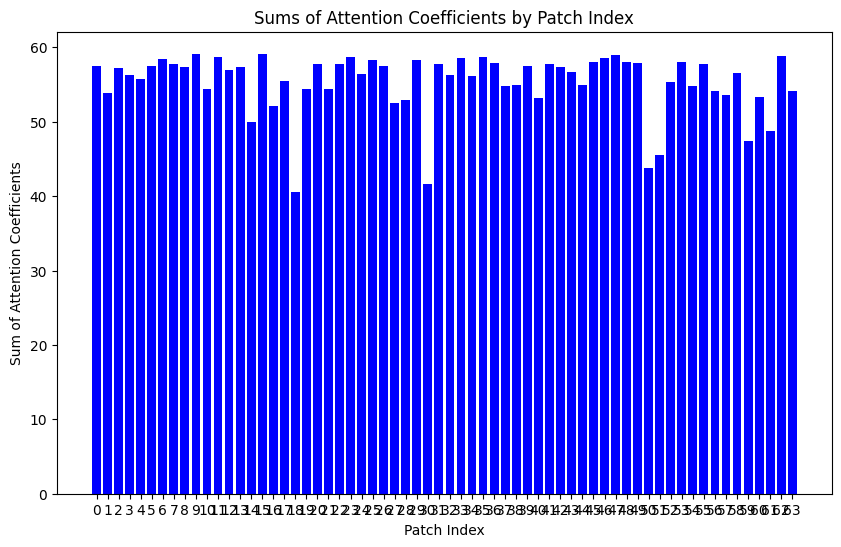

tensor([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
        1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  8%|▊         | 8/100 [3:49:23<44:41:49, 1749.02s/it]

torch.Size([240, 64, 16])
Row sums: [57.47091  54.323112 57.201973 56.57055  55.651016 57.462917 58.43279
 57.845642 57.66292  59.149742 54.08373  58.679764 56.80098  57.367035
 50.052437 59.233326 52.475464 55.707664 40.304546 54.302116 57.890076
 54.33654  57.76963  58.80121  56.115883 58.344276 57.516895 52.434372
 52.724586 58.404625 41.45816  57.58178  56.153458 58.711353 56.09961
 58.8294   57.972275 54.679882 54.693283 57.72865  53.10897  57.75492
 57.470947 56.905224 54.816376 58.088306 58.51955  59.049675 58.0803
 57.77173  43.36479  45.092457 55.08824  58.241234 55.135475 57.64803
 54.027527 53.2621   56.7231   47.938484 53.81382  48.332134 58.87422
 53.87414 ]


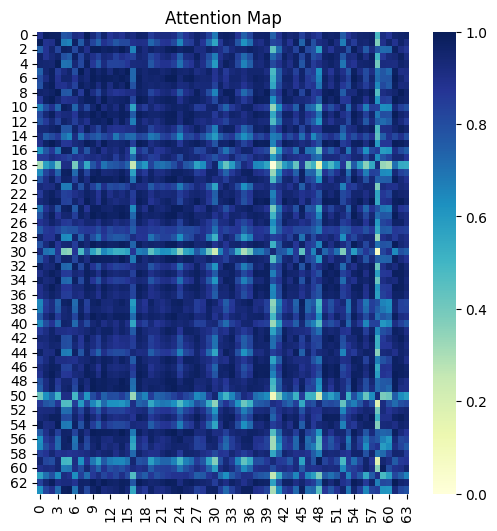

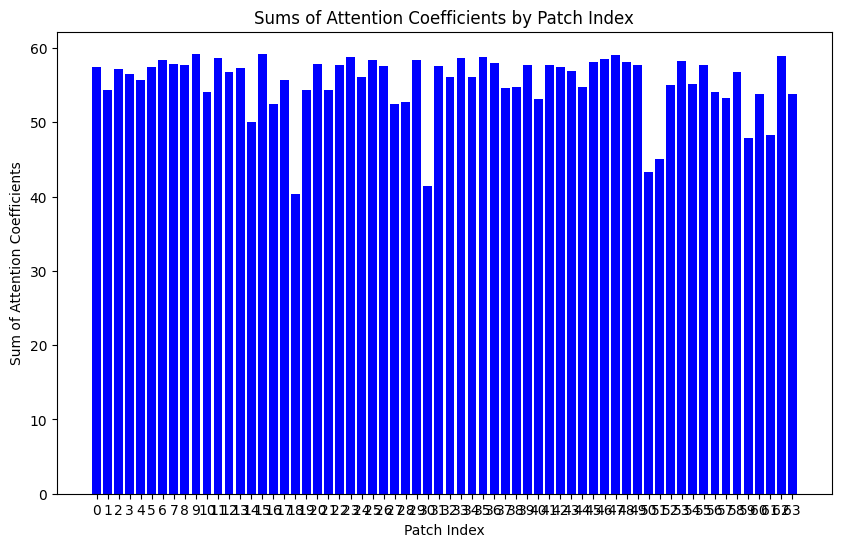

tensor([2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2,
        1, 2, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2,
        2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

  9%|▉         | 9/100 [4:18:30<44:11:40, 1748.35s/it]

torch.Size([240, 64, 16])
Row sums: [57.429623 54.76976  57.21879  56.93444  55.64839  57.47168  58.43624
 58.0151   57.809715 59.19458  53.823235 58.698093 56.732685 57.525894
 50.21718  59.33526  52.746094 55.90545  40.06298  54.30999  58.019424
 54.29774  57.821472 58.949215 55.8266   58.38873  57.531693 52.311134
 52.614788 58.388405 41.33067  57.469013 55.98257  58.825035 56.080154
 58.89085  58.0226   54.54608  54.522404 57.856277 53.03092  57.785713
 57.6465   57.096436 54.724045 58.12877  58.508633 59.12254  58.117004
 57.795525 43.115997 45.02307  54.979286 58.460167 55.48664  57.52964
 53.95432  52.996407 56.808655 48.487305 54.257095 48.036953 58.940296
 53.63874 ]


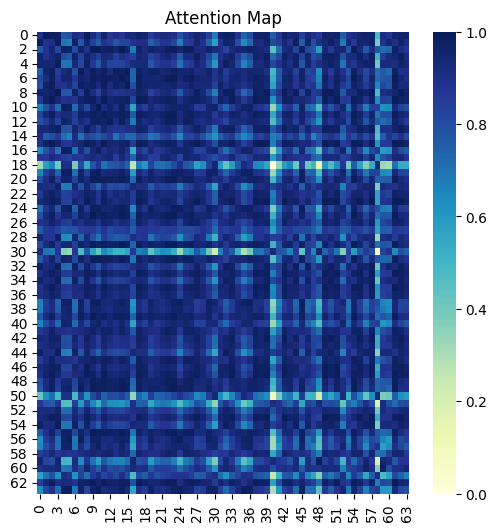

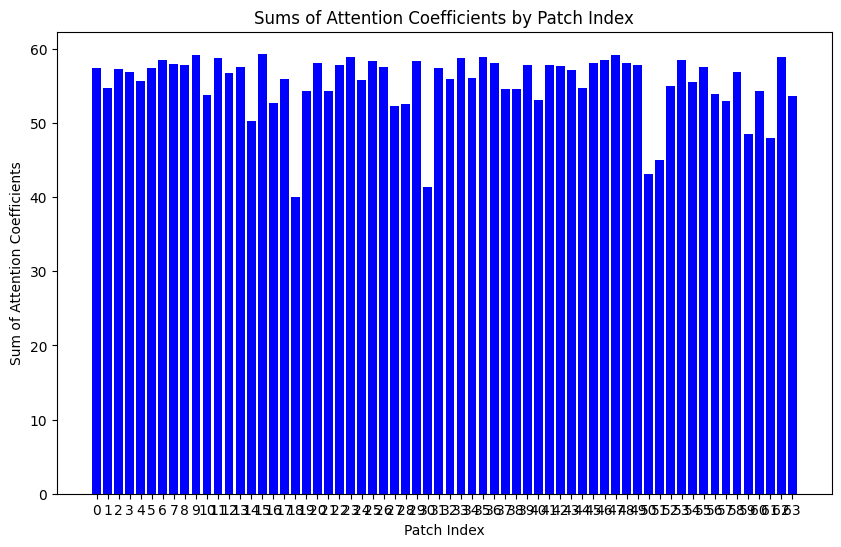

tensor([2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1,
        1, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0,
        0, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0,
        0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1,
        1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 10%|█         | 10/100 [4:47:51<43:48:31, 1752.35s/it]

torch.Size([240, 64, 16])
Row sums: [57.391922 55.22298  57.17048  57.315834 55.678417 57.496483 58.433723
 58.185028 57.844585 59.242382 53.568527 58.70668  56.695625 57.72104
 50.461197 59.448654 52.852394 56.12259  39.840275 54.324165 58.126186
 54.305485 57.90613  59.11136  55.57399  58.410797 57.573425 52.236137
 52.54319  58.350853 41.297043 57.439148 55.84342  58.95436  56.071777
 58.94863  58.117355 54.421997 54.416473 57.95616  53.004578 57.85053
 57.868492 57.31045  54.720715 58.19749  58.565    59.22966  58.097763
 57.88559  43.150215 45.315086 55.055603 58.68343  55.88382  57.496185
 53.87037  52.76084  56.87152  49.087532 54.7321   47.881546 59.03482
 53.4115  ]


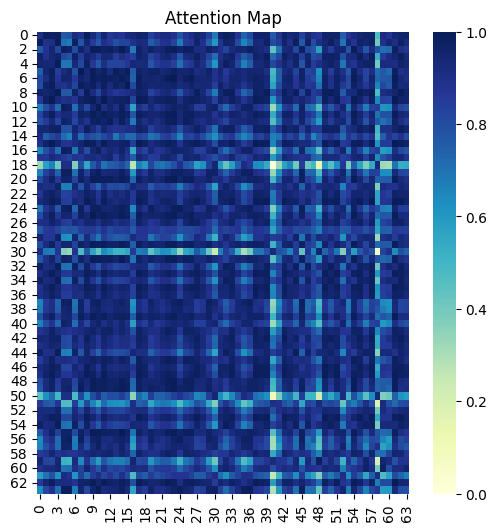

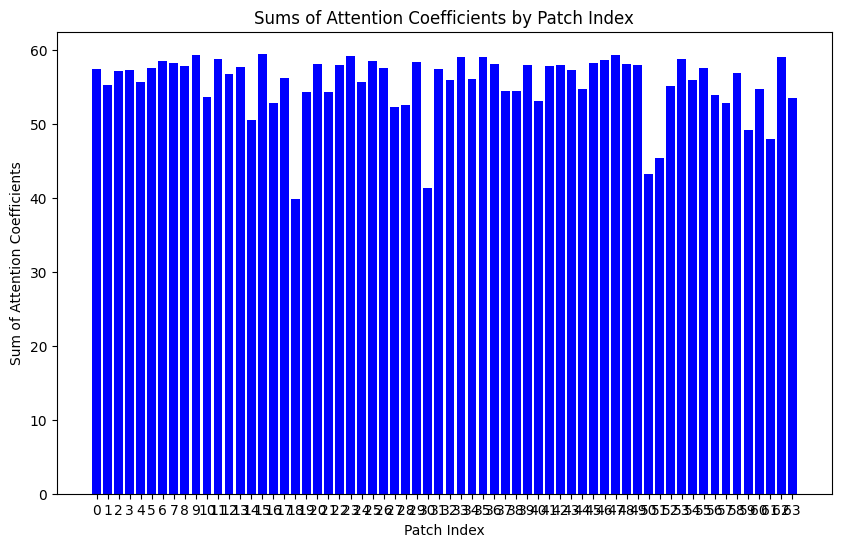

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 11%|█         | 11/100 [5:16:57<43:16:16, 1750.30s/it]

torch.Size([240, 64, 16])
Row sums: [57.28031  55.544773 57.024246 57.60704  55.657234 57.460625 58.35337
 58.275047 57.778122 59.211105 53.25753  58.632378 56.594913 57.804146
 50.63654  59.49185  52.830765 56.282173 39.579483 54.23635  58.14976
 54.270355 57.93377  59.204987 55.241844 58.362778 57.561096 52.140377
 52.472164 58.237152 41.279457 57.35904  55.660072 59.01996  56.084145
 58.94803  58.17041  54.321335 54.31938  57.99492  52.99697  57.862206
 58.04589  57.46756  54.705353 58.22078  58.571144 59.275227 57.977417
 57.933712 43.252403 45.688328 55.12178  58.825726 56.237526 57.49225
 53.722603 52.453705 56.85324  49.645424 55.13642  47.717175 59.07083
 53.128857]


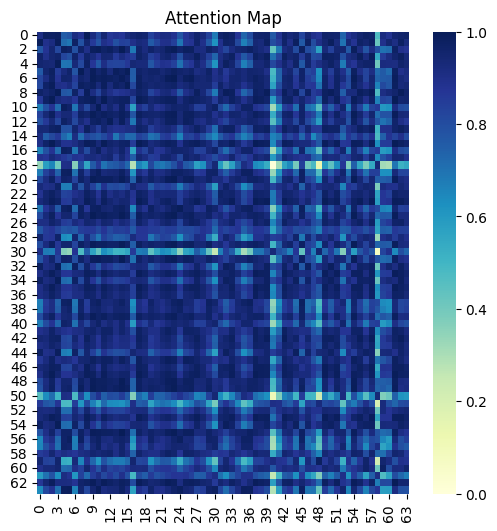

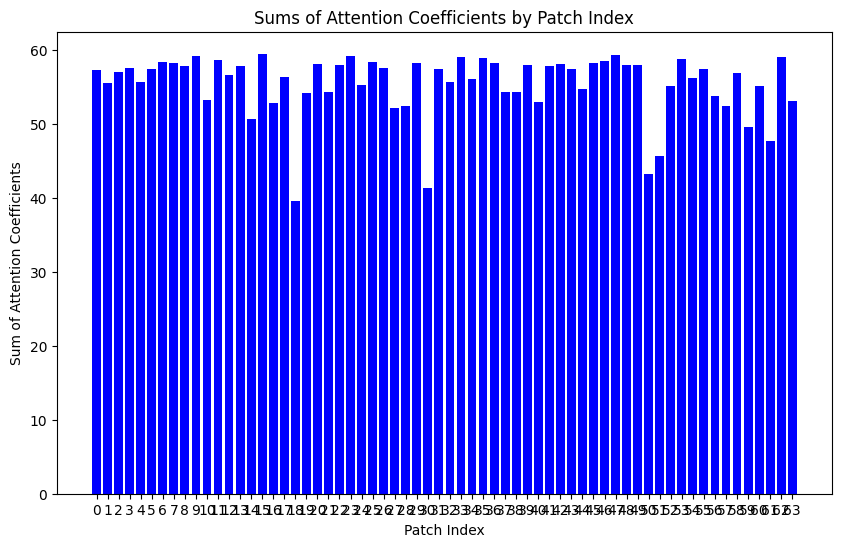

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 12%|█▏        | 12/100 [5:47:11<43:15:27, 1769.64s/it]

torch.Size([240, 64, 16])
Row sums: [57.121346 55.753525 56.831554 57.817436 55.598198 57.395252 58.225876
 58.32002  57.667107 59.12655  52.897835 58.50183  56.454086 57.800323
 50.728394 59.48828  52.76375  56.408157 39.308937 54.080746 58.12667
 54.201973 57.922867 59.25109  54.857166 58.296165 57.517624 52.047264
 52.47442  58.103424 41.302486 57.231544 55.44747  59.04342  56.150093
 58.932777 58.191154 54.29828  54.254723 58.016724 53.015705 57.838753
 58.186733 57.581276 54.662735 58.22502  58.52334  59.277832 57.793858
 57.95314  43.350937 46.030655 55.134476 58.90356  56.5365   57.517456
 53.5684   52.099915 56.78963  50.141655 55.459415 47.523537 59.07201
 52.89161 ]


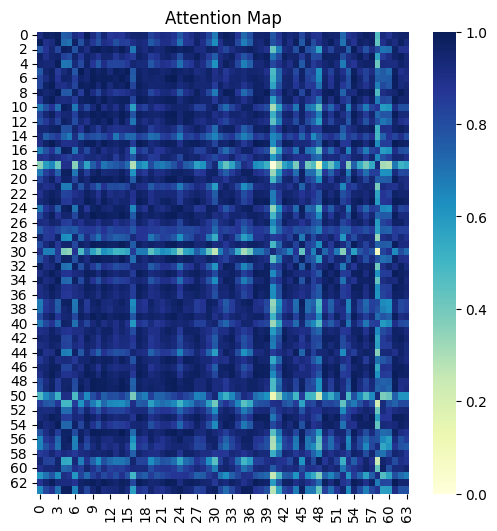

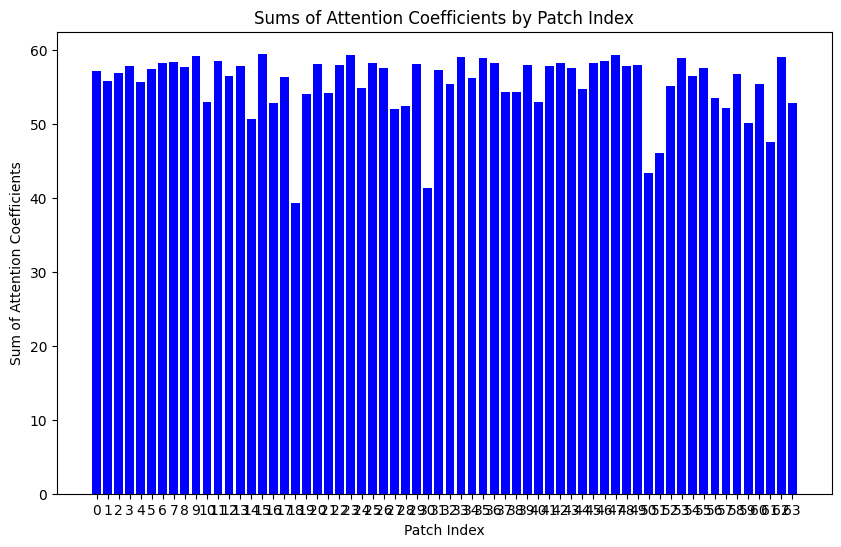

tensor([0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 13%|█▎        | 13/100 [6:17:15<43:01:06, 1780.07s/it]

torch.Size([240, 64, 16])
Row sums: [56.947495 55.892464 56.652325 57.963284 55.517303 57.333893 58.08828
 58.359104 57.58522  59.02378  52.514572 58.344727 56.302834 57.744568
 50.763382 59.463448 52.712044 56.517162 39.066788 53.89517  58.09646
 54.117477 57.89209  59.27162  54.45536  58.256588 57.46386  51.97159
 52.579563 58.0285   41.391125 57.083122 55.23497  59.047096 56.247406
 58.916027 58.19366  54.337597 54.217392 58.05065  53.079292 57.79724
 58.286907 57.664715 54.592182 58.217377 58.43796  59.26257  57.58737
 57.95925  43.40097  46.26274  55.08103  58.936707 56.758965 57.56839
 53.470634 51.729736 56.720383 50.55722  55.692047 47.316208 59.061794
 52.784035]


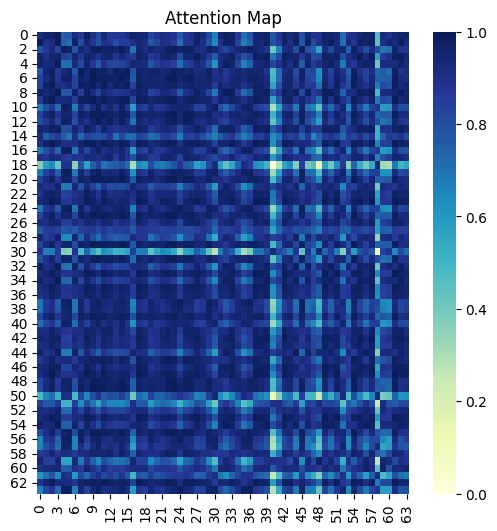

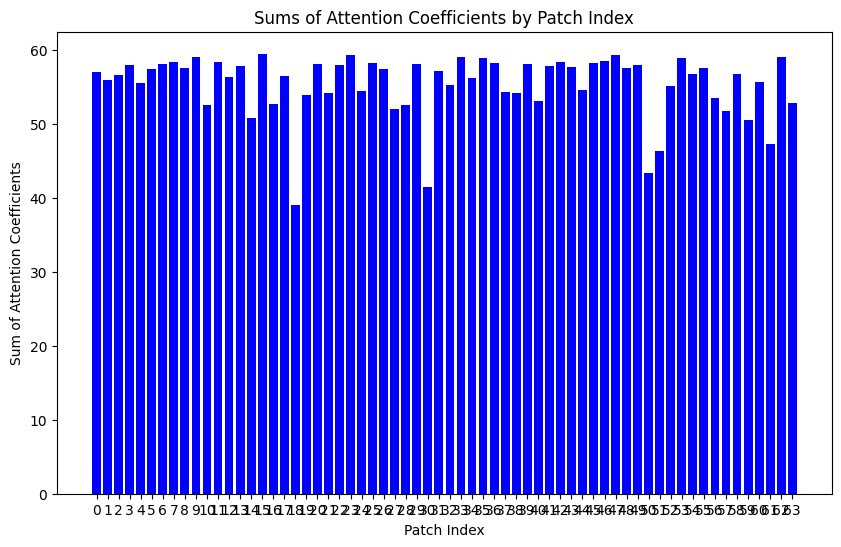

tensor([2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1,
        2, 1, 2, 1, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 0,
        1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0,
        0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 2, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 14%|█▍        | 14/100 [6:46:47<42:28:11, 1777.81s/it]

torch.Size([240, 64, 16])
Row sums: [56.790443 56.020386 56.535538 58.085705 55.44159  57.305016 57.992195
 58.425877 57.57905  58.95334  52.1519   58.204327 56.17581  57.675518
 50.775658 59.451836 52.71125  56.63275  38.889072 53.719025 58.098007
 54.04377  57.869415 59.29807  54.07954  58.266632 57.415115 51.924107
 52.761494 58.04553  41.52465  56.94847  55.053528 59.062862 56.36519
 58.907913 58.20509  54.428333 54.209606 58.122265 53.198387 57.76528
 58.364326 57.74606  54.50889  58.214947 58.34617  59.263557 57.402916
 57.979755 43.410286 46.38334  54.982307 58.961884 56.92451  57.653297
 53.462273 51.384323 56.68409  50.90994  55.865597 47.126354 59.070244
 52.789486]


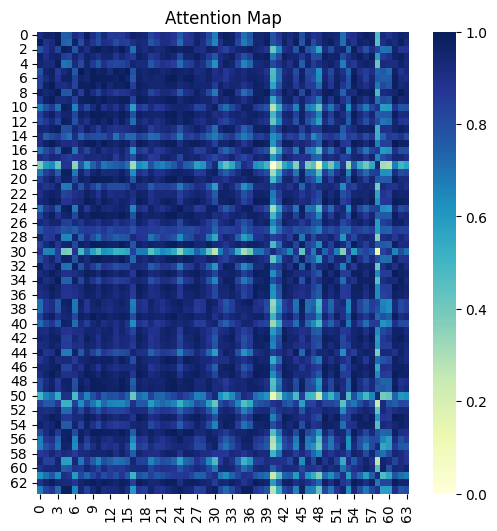

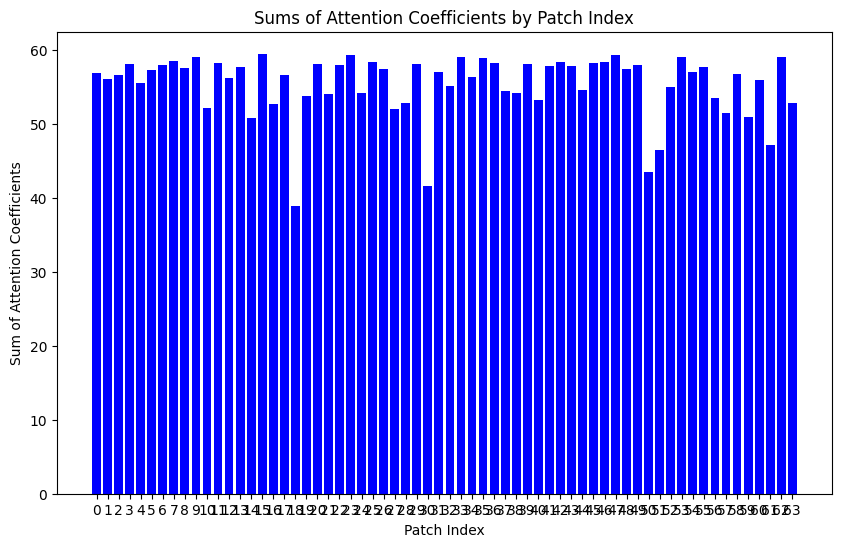

tensor([2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
        0, 2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 2,
        0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1,
        2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 15%|█▌        | 15/100 [7:16:17<41:55:12, 1775.44s/it]

torch.Size([240, 64, 16])
Row sums: [56.622543 56.156864 56.45217  58.196358 55.36603  57.289783 57.919495
 58.5007   57.598625 58.894196 51.806465 58.076927 56.06788  57.597965
 50.778522 59.440544 52.690567 56.73998  38.751083 53.554626 58.114662
 53.971863 57.843674 59.321358 53.72602  58.286724 57.350216 51.871105
 52.932457 58.091797 41.627575 56.8335   54.88026  59.07923  56.453033
 58.887638 58.21255  54.50505  54.197845 58.19655  53.340508 57.729904
 58.41597  57.81633  54.41349  58.20015  58.23692  59.26738  57.211407
 58.011307 43.42009  46.453987 54.859596 58.977043 57.054573 57.72712
 53.475807 51.055893 56.653908 51.224693 56.004837 46.96373  59.083145
 52.795044]


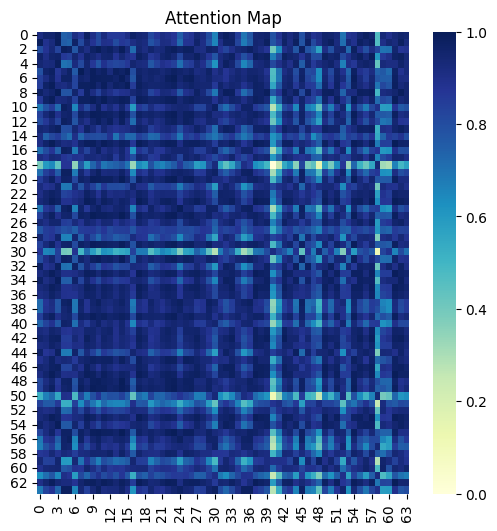

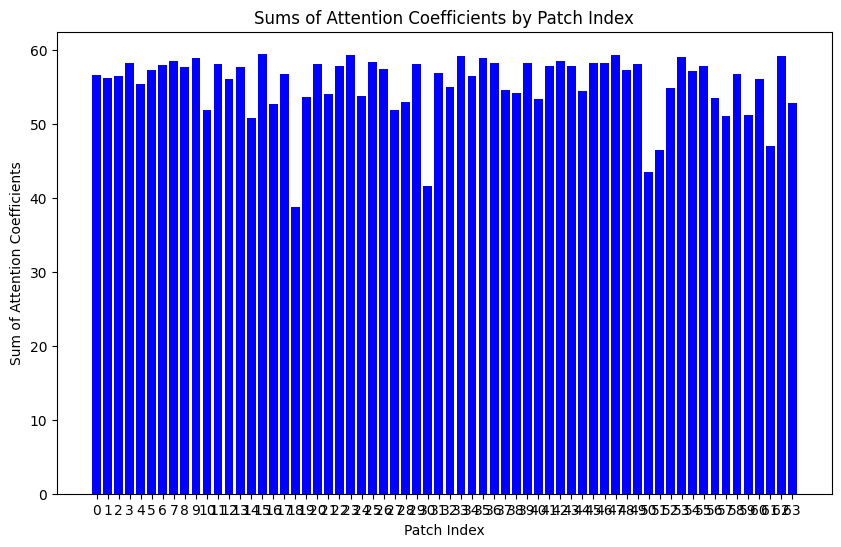

tensor([2, 1, 2, 1, 2, 0, 2, 2, 2, 0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2,
        2, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 2,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1,
        2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 16%|█▌        | 16/100 [7:46:25<41:39:16, 1785.19s/it]

torch.Size([240, 64, 16])
Row sums: [56.417667 56.314728 56.37175  58.30477  55.287373 57.269627 57.849644
 58.568306 57.599422 58.818966 51.464684 57.963486 55.979607 57.528748
 50.782555 59.419518 52.593445 56.83162  38.61686  53.40683  58.137486
 53.890556 57.80768  59.336174 53.372128 58.28428  57.260044 51.78637
 53.011612 58.10994  41.640594 56.74147  54.683205 59.088707 56.46952
 58.845573 58.20801  54.51391  54.151672 58.24391  53.47439  57.679867
 58.44463  57.869724 54.31216  58.17036  58.110058 59.265404 56.9806
 58.051056 43.482067 46.540085 54.75916  58.98034  57.16677  57.74505
 53.442017 50.72003  56.607536 51.525032 56.128815 46.828033 59.090973
 52.704945]


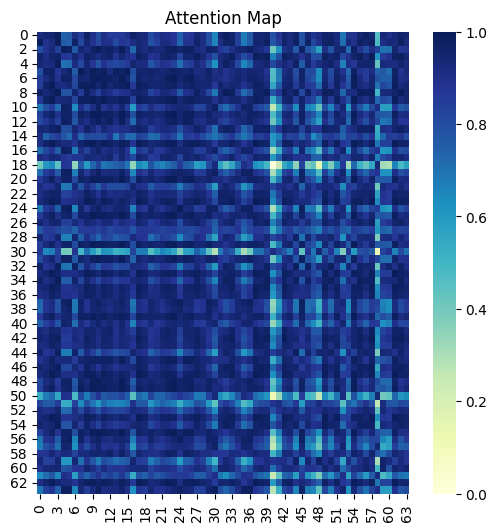

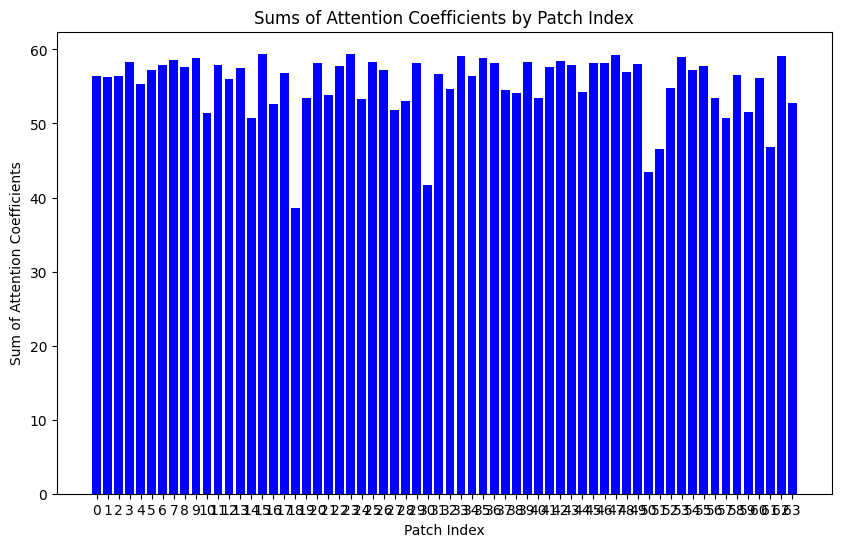

tensor([2, 1, 2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2,
        1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2,
        0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1,
        2, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 17%|█▋        | 17/100 [8:16:21<41:13:53, 1788.35s/it]

torch.Size([240, 64, 16])
Row sums: [56.17318  56.49009  56.27681  58.411007 55.210114 57.239544 57.77127
 58.624725 57.560677 58.721565 51.10968  57.856075 55.915348 57.475758
 50.798157 59.388733 52.407856 56.911148 38.47137  53.27038  58.16262
 53.8031   57.76406  59.345257 53.010292 58.25577  57.149452 51.671726
 53.00778  58.079334 41.580353 56.680607 54.465645 59.09389  56.430855
 58.782806 58.194668 54.46117  54.079414 58.257656 53.59762  57.61644
 58.458233 57.912025 54.232445 58.143105 57.979553 59.260094 56.702232
 58.098454 43.637268 46.701954 54.723    58.976456 57.276443 57.715706
 53.351776 50.361237 56.538147 51.827747 56.250095 46.73555  59.094486
 52.52963 ]


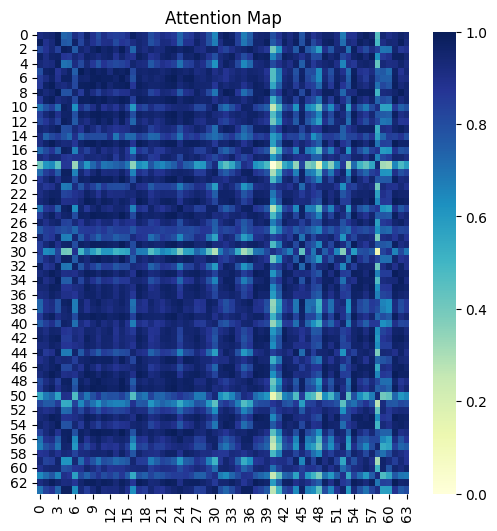

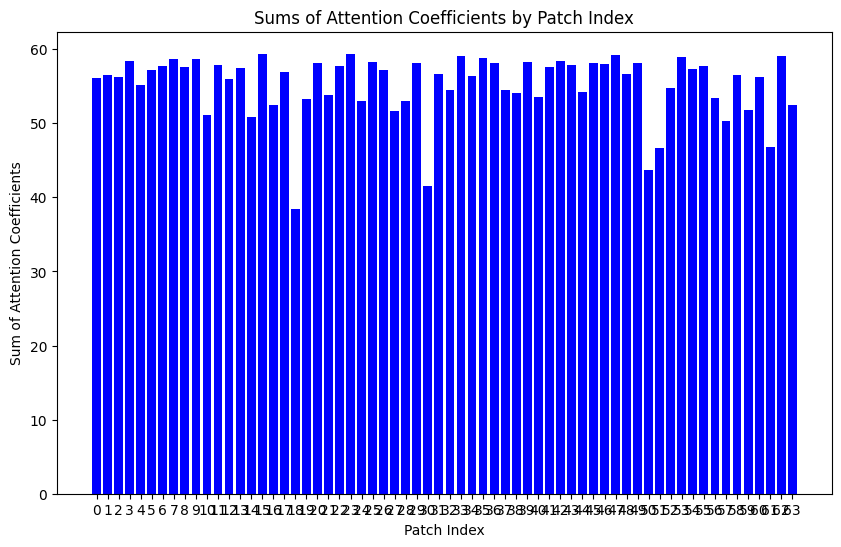

tensor([2, 1, 2, 1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0,
        0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 0, 1,
        0, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 18%|█▊        | 18/100 [8:45:57<40:39:13, 1784.80s/it]

torch.Size([240, 64, 16])
Row sums: [55.913246 56.67269  56.159126 58.51691  55.14746  57.205315 57.683266
 58.674335 57.483185 58.6117   50.73304  57.73168  55.8777   57.4349
 50.840977 59.357224 52.153736 56.992302 38.309566 53.133778 58.18318
 53.728977 57.72607  59.360367 52.64918  58.215855 57.036476 51.552986
 52.983315 58.01043  41.509056 56.665394 54.263863 59.106964 56.389633
 58.71219  58.18504  54.38994  54.026833 58.248398 53.732597 57.557873
 58.476837 57.960243 54.21962  58.14903  57.87436  59.263783 56.38733
 58.160088 43.89949  46.98654  54.77166  58.979126 57.40597  57.685135
 53.23091  49.978935 56.449413 52.159996 56.384094 46.71263  59.104046
 52.308975]


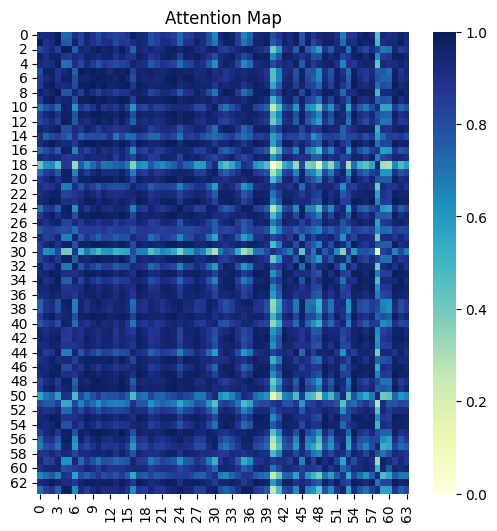

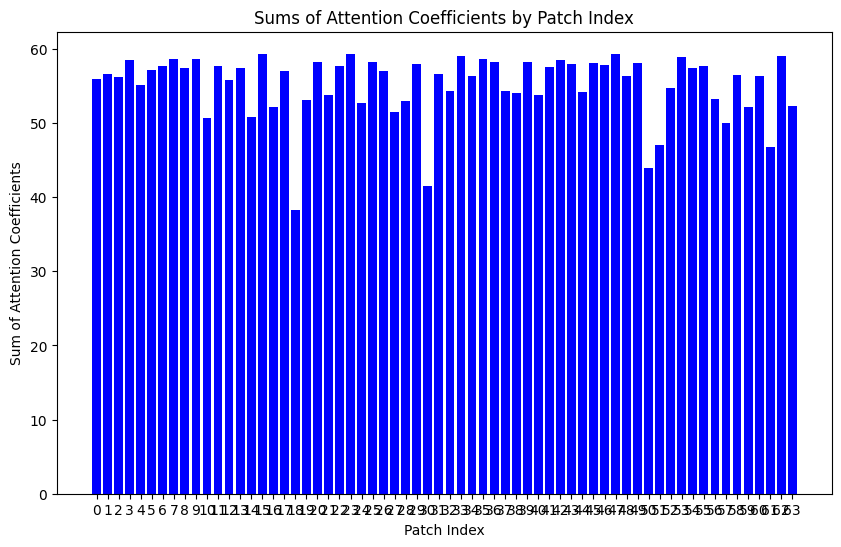

tensor([2, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1,
        2, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 0, 2, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 0, 0, 1, 1, 0,
        0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        0, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1,
        0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 19%|█▉        | 19/100 [9:15:41<40:09:05, 1784.51s/it]

torch.Size([240, 64, 16])
Row sums: [55.668114 56.847736 56.0271   58.63179  55.11313  57.175373 57.60006
 58.729332 57.39059  58.505264 50.36432  57.594494 55.85965  57.402245
 50.90895  59.339993 51.86815  57.095398 38.13601  52.989292 58.194874
 53.68782  57.711422 59.3982   52.29654  58.18941  56.945717 51.46426
 53.00653  57.928947 41.488472 56.69638  54.118294 59.14498  56.41671
 58.65715  58.195053 54.363487 54.052307 58.24064  53.901222 57.529526
 58.531555 58.033726 54.28776  58.204872 57.81691  59.293648 56.054974
 58.248318 44.25659  47.38984  54.88933  59.00645  57.573143 57.732224
 53.117287 49.58995  56.358532 52.540596 56.54239  46.756596 59.135918
 52.091496]


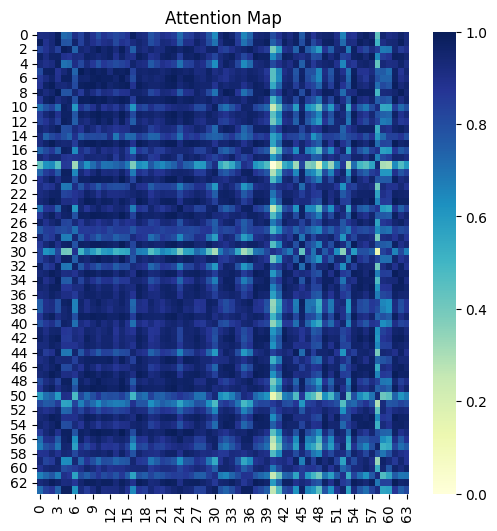

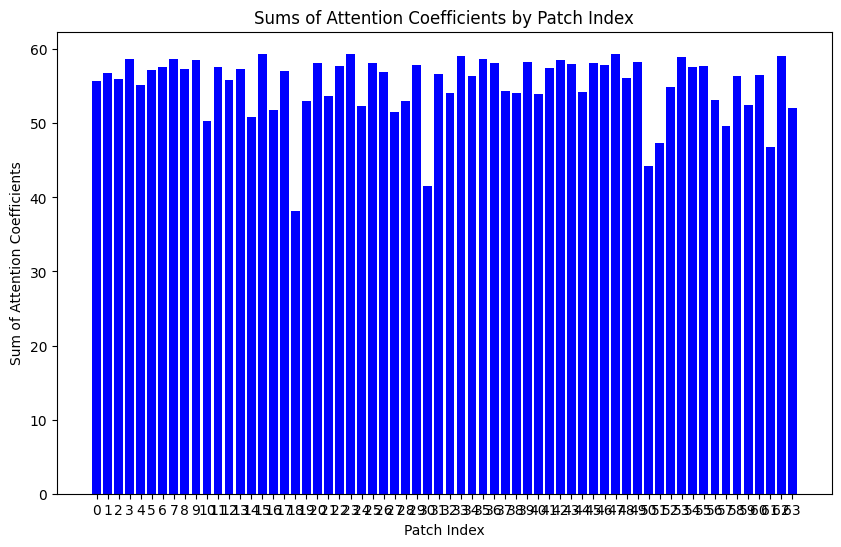

tensor([2, 0, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0,
        0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 0, 1, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1,
        0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 20%|██        | 20/100 [9:45:25<39:38:57, 1784.22s/it]

torch.Size([240, 64, 16])
Row sums: [55.447647 57.013985 55.897675 58.76388  55.113358 57.15778  57.537697
 58.80374  57.30402  58.415268 50.017227 57.45903  55.85361  57.384735
 50.971268 59.348858 51.58223  57.233932 37.957645 52.83716  58.211304
 53.68393  57.730137 59.470028 51.96172  58.20329  56.90119  51.430466
 53.118233 57.86016  41.539207 56.758957 54.040344 59.21972  56.549004
 58.6456   58.23624  54.42404  54.168125 58.261513 54.11358  57.541122
 58.63922  58.1427   54.408176 58.311687 57.800182 59.36107  55.726196
 58.371624 44.670845 47.856606 55.030605 59.069847 57.775948 57.880745
 53.052597 49.20829  56.284653 52.961708 56.721638 46.832695 59.20245
 51.93309 ]


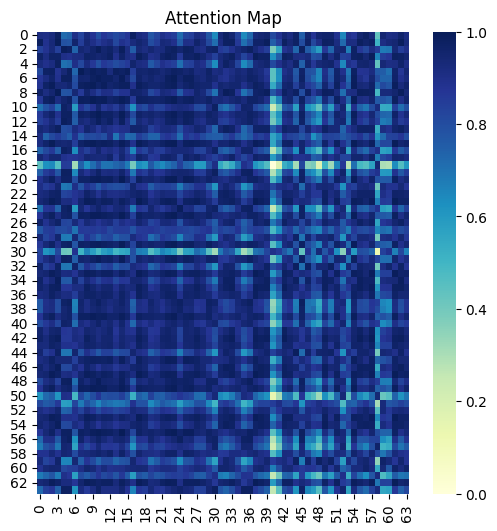

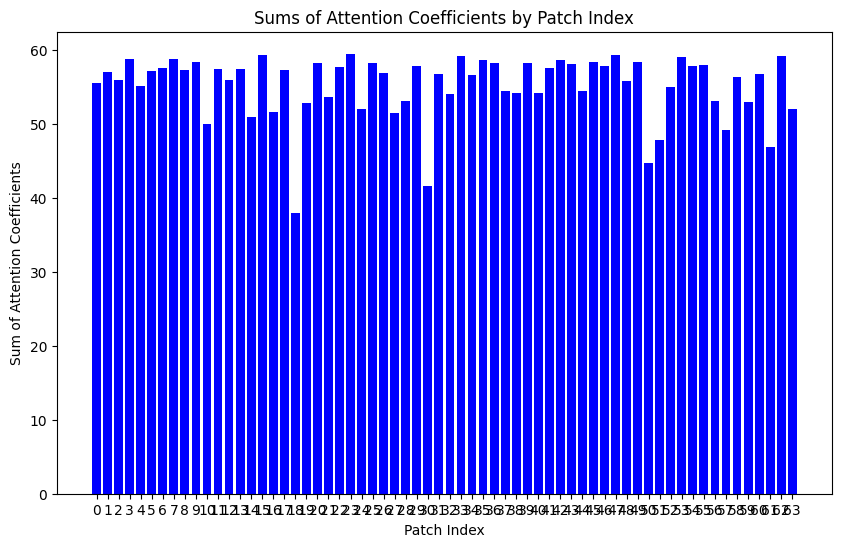

tensor([2, 0, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1,
        2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 2, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 0, 1, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0,
        0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1,
        0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 21%|██        | 21/100 [10:15:04<39:07:14, 1782.71s/it]

torch.Size([240, 64, 16])
Row sums: [55.229904 57.156204 55.763    58.890244 55.126358 57.136574 57.483006
 58.881447 57.211937 58.326042 49.67109  57.307564 55.841442 57.363678
 50.998142 59.363686 51.2961   57.387577 37.770058 52.667107 58.221924
 53.694283 57.75916  59.55412  51.633625 58.251205 56.900467 51.443443
 53.306396 57.796013 41.648235 56.82587  54.011814 59.31032  56.749157
 58.66632  58.292786 54.549812 54.340374 58.303864 54.351288 57.56885
 58.770348 58.265236 54.530556 58.439857 57.788124 59.444416 55.400642
 58.508114 45.087917 48.3154   55.144135 59.148075 57.979668 58.0866
 53.04662  48.821476 56.217392 53.387505 56.892258 46.902702 59.283337
 51.854736]


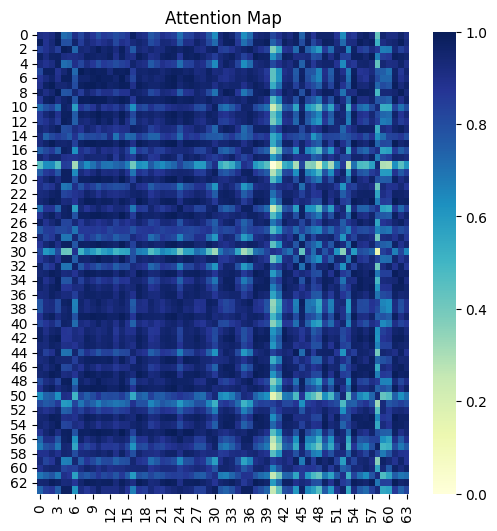

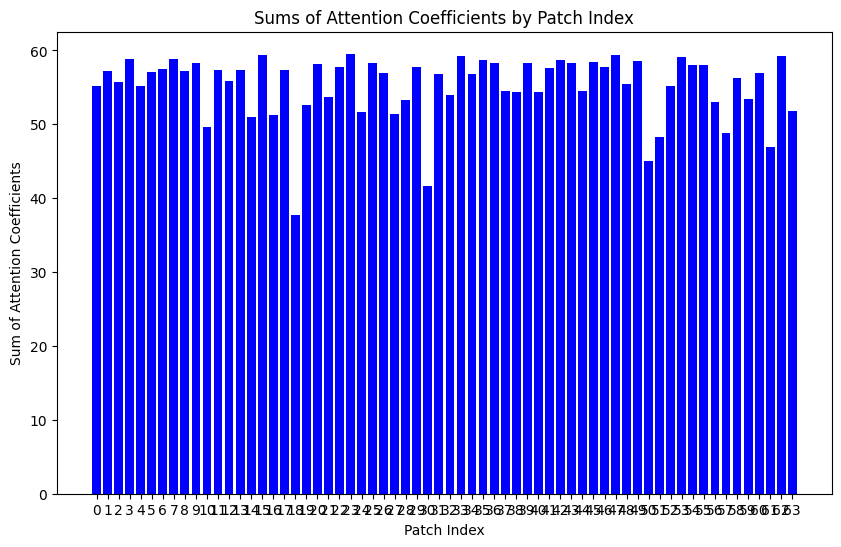

tensor([2, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1,
        2, 1, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 22%|██▏       | 22/100 [10:45:02<38:43:33, 1787.35s/it]

torch.Size([240, 64, 16])
Row sums: [54.902054 57.16871  55.526825 58.888313 55.036995 57.001255 57.329376
 58.845306 57.01333  58.12574  49.226402 57.02552  55.7207   57.21968
 50.893356 59.26316  50.91549  57.434288 37.51051  52.380478 58.115734
 53.6063   57.675224 59.52658  51.219833 58.216835 56.81918  51.387375
 53.445976 57.62736  41.720886 56.79515  53.924965 59.29409  56.86738
 58.583282 58.247208 54.609085 54.43799  58.247555 54.5009   57.48896
 58.7843   58.278976 54.52961  58.460987 57.653294 59.420166 54.979973
 58.537243 45.405914 48.649296 55.116287 59.117546 58.054203 58.212357
 52.997597 48.33586  56.049583 53.695183 56.934338 46.880577 59.25595
 51.74682 ]


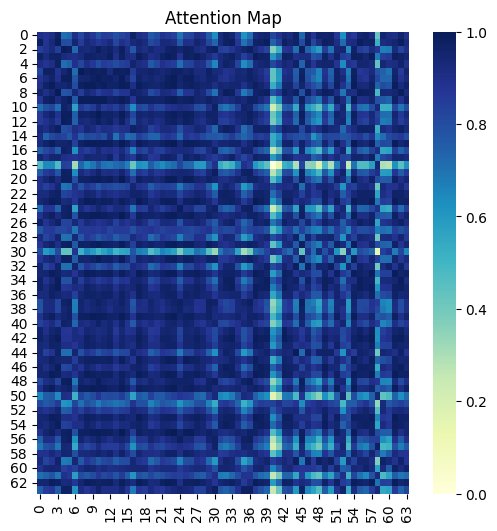

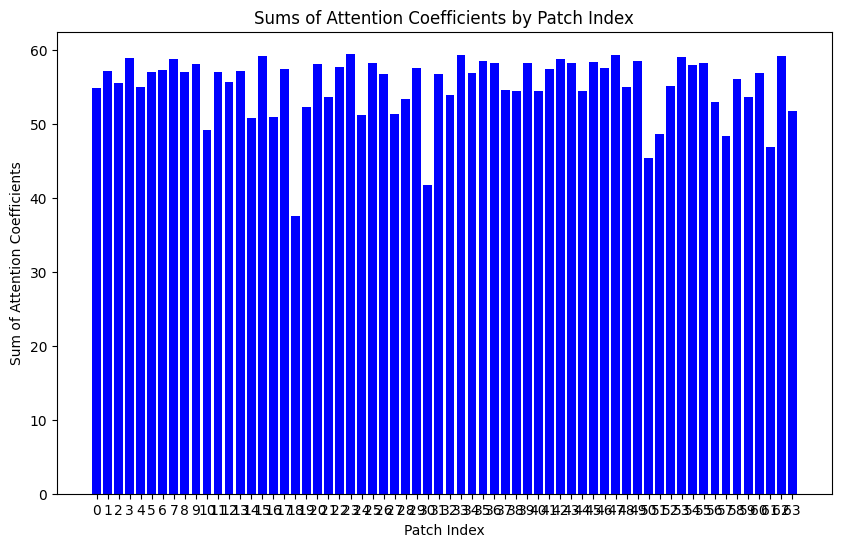

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 23%|██▎       | 23/100 [11:15:49<38:36:34, 1805.12s/it]

torch.Size([240, 64, 16])
Row sums: [54.555714 57.165413 55.304382 58.858364 54.93498  56.856674 57.186638
 58.7961   56.82907  57.92085  48.775974 56.720024 55.608215 57.047173
 50.751587 59.147903 50.528698 57.463623 37.257782 52.07617  57.999134
 53.50532  57.56951  59.48546  50.82311  58.19068  56.72451  51.317947
 53.58954  57.455902 41.794327 56.77517  53.84896  59.26834  56.95677
 58.47294  58.19213  54.661373 54.52385  58.17758  54.646057 57.388725
 58.76253  58.277103 54.491726 58.466415 57.48606  59.38547  54.551453
 58.556713 45.715294 48.94468  55.04881  59.07313  58.090874 58.33642
 52.97797  47.839676 55.882713 53.967327 56.94237  46.859978 59.217655
 51.65255 ]


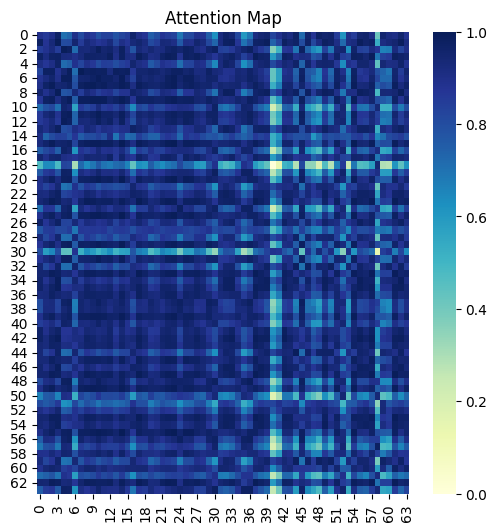

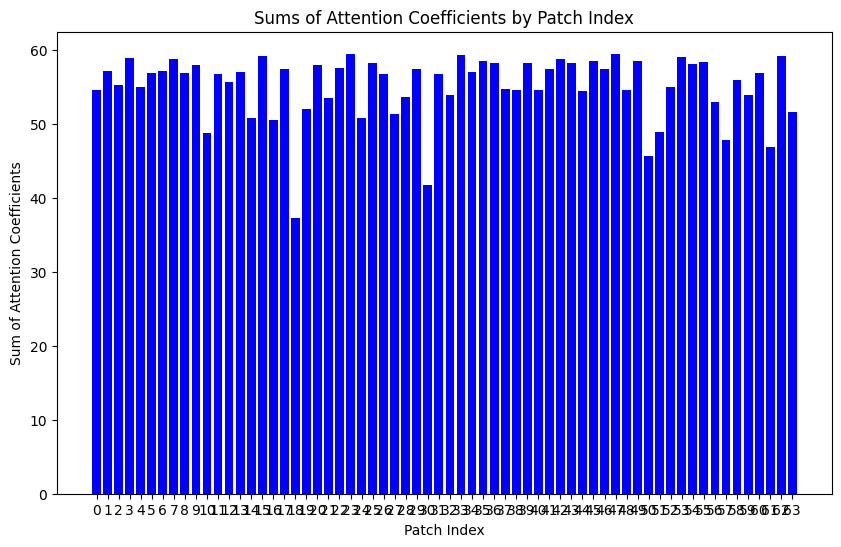

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2,
        0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1,
        2, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 24%|██▍       | 24/100 [11:45:24<37:55:17, 1796.28s/it]

torch.Size([240, 64, 16])
Row sums: [54.18006  57.16404  55.0996   58.803547 54.81909  56.70278  57.051674
 58.730762 56.65267  57.705128 48.322044 56.405884 55.517525 56.85089
 50.585533 59.016823 50.12     57.47069  37.01423  51.765686 57.8781
 53.387573 57.440582 59.428913 50.439102 58.15722  56.590687 51.205494
 53.69874  57.26613  41.829887 56.766365 53.74994  59.229836 56.986717
 58.327698 58.118088 54.66951  54.57225  58.075603 54.774414 57.26181
 58.70444  58.254936 54.42651  58.45081  57.28997  59.336838 54.08748
 58.56433  46.03739  49.223877 54.96246  59.01044  58.0915   58.436474
 52.954727 47.325893 55.717247 54.210915 56.918213 46.843582 59.16549
 51.511868]


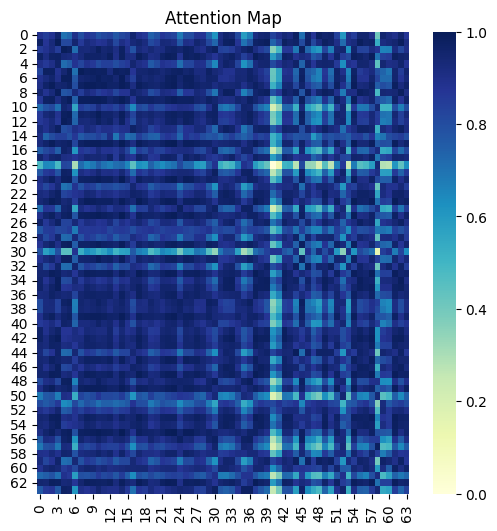

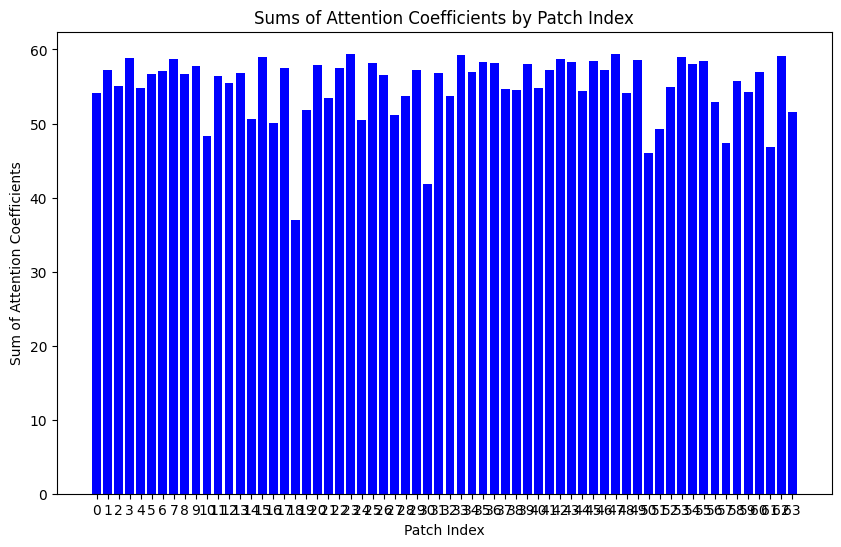

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2,
        0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 1,
        2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 25%|██▌       | 25/100 [12:15:25<37:26:57, 1797.56s/it]

torch.Size([240, 64, 16])
Row sums: [53.7678   57.174976 54.899036 58.72795  54.697052 56.530163 56.912613
 58.645073 56.452274 57.463768 47.851612 56.08384  55.443176 56.643723
 50.410927 58.868042 49.669205 57.457573 36.76346  51.450493 57.753075
 53.259514 57.29749  59.35785  50.050392 58.102203 56.414764 51.042114
 53.763157 57.031857 41.822563 56.766533 53.623444 59.178734 56.966248
 58.152733 58.018284 54.61975  54.580414 57.929424 54.879265 57.114693
 58.619804 58.21311  54.3619   58.4146   57.091057 59.27471  53.57185
 58.558975 46.382484 49.51888  54.892822 58.931396 58.06584  58.501884
 52.896507 46.77939  55.548737 54.445557 56.868736 46.829975 59.099537
 51.291473]


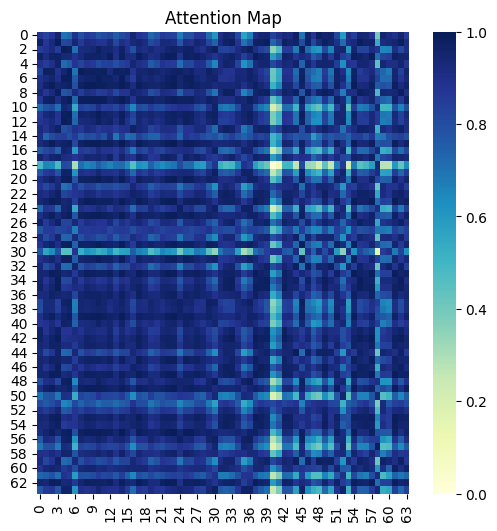

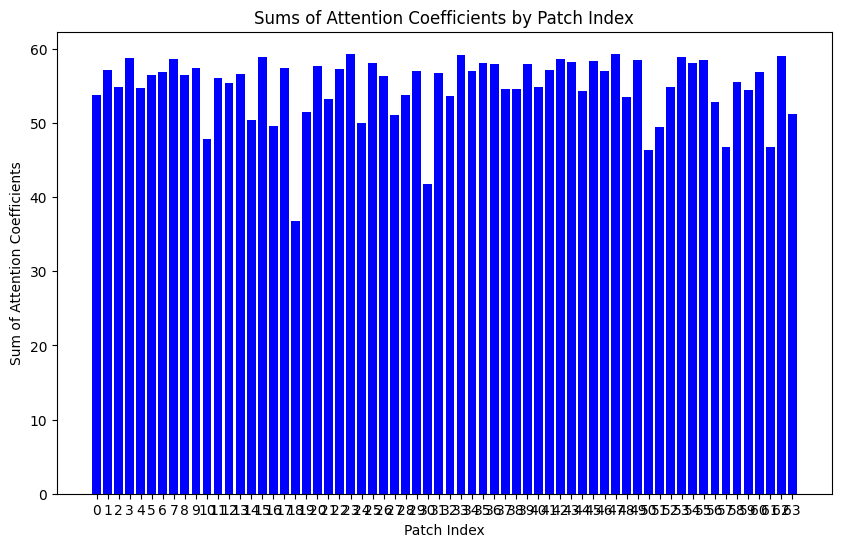

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0,
        0, 2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 0, 1,
        0, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 26%|██▌       | 26/100 [12:45:30<36:59:36, 1799.68s/it]

torch.Size([240, 64, 16])
Row sums: [53.332115 57.2015   54.6812   58.635612 54.58264  56.329666 56.76045
 58.536613 56.209038 57.190666 47.344265 55.732746 55.370834 56.435566
 50.234768 58.700333 49.168724 57.431183 36.478516 51.11476  57.616356
 53.13479  57.153328 59.2749   49.641075 58.020218 56.213055 50.839302
 53.80139  56.739525 41.80253  56.77349  53.498158 59.1185   56.93174
 57.962097 57.89161  54.527607 54.564995 57.736954 54.964333 56.968285
 58.52468  58.15675  54.322636 58.363457 56.922386 59.204056 53.0037
 58.54135  46.74816  49.853313 54.867645 58.84417  58.02636  58.542015
 52.790497 46.194046 55.37219  54.693256 56.801186 46.81637  59.022392
 50.995975]


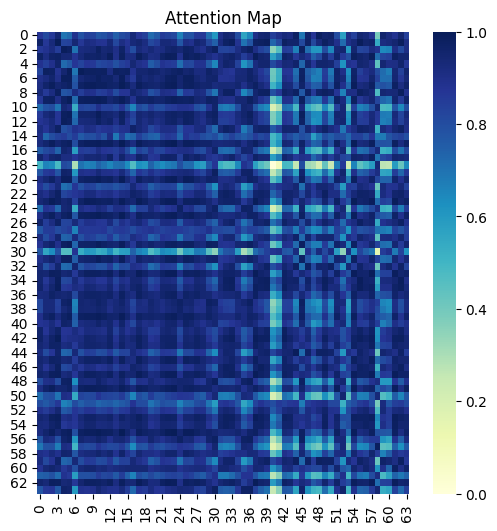

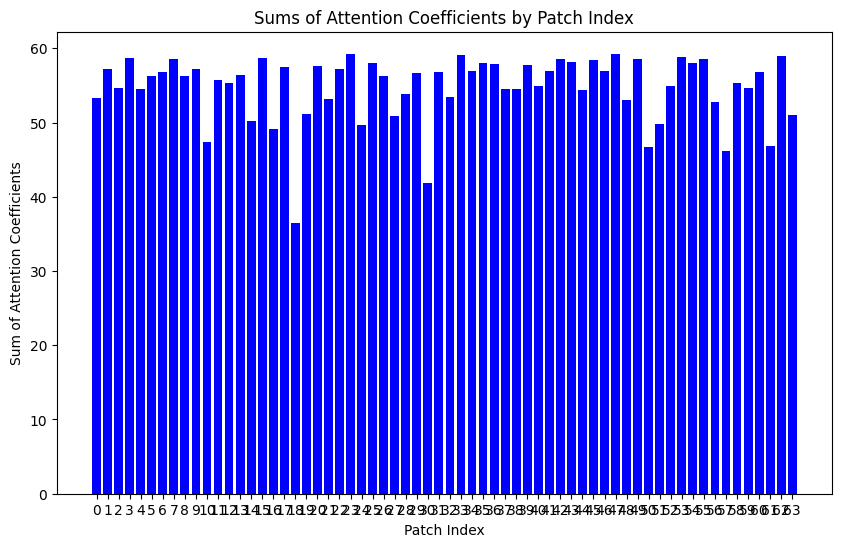

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 0,
        0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 27%|██▋       | 27/100 [13:15:26<36:28:18, 1798.61s/it]

torch.Size([240, 64, 16])
Row sums: [52.903297 57.247086 54.431683 58.532997 54.4918   56.101913 56.597343
 58.408745 55.939186 56.89146  46.805458 55.336807 55.28751  56.23329
 50.054363 58.51731  48.63047  57.402214 36.146427 50.74349  57.461777
 53.02944  57.019646 59.185356 49.211163 57.917774 56.021126 50.627586
 53.84202  56.39355  41.81819  56.78729  53.41824  59.056324 56.926727
 57.781693 57.746452 54.42854  54.55316  57.50708  55.042995 56.847572
 58.441135 58.094997 54.313324 58.30753  56.804237 59.134506 52.39422
 58.516743 47.139114 50.240093 54.89615  58.76162  57.984432 58.578102
 52.649208 45.585922 55.190952 54.972683 56.72182  46.80178  58.939564
 50.65427 ]


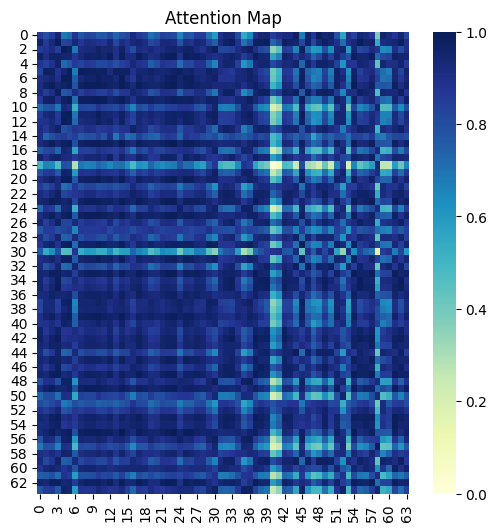

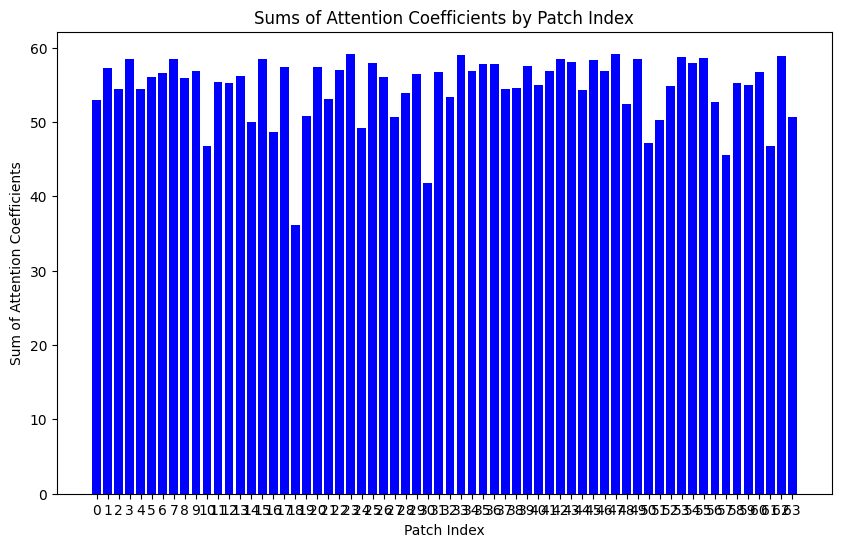

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 0, 1, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 28%|██▊       | 28/100 [13:45:16<35:55:29, 1796.25s/it]

torch.Size([240, 64, 16])
Row sums: [52.50149  57.314938 54.150517 58.42553  54.432247 55.85321  56.43316
 58.267498 55.664955 56.574528 46.25724  54.902897 55.18598  56.04221
 49.85659  58.32518  48.074173 57.377975 35.782684 50.34105  57.290905
 52.950523 56.901466 59.093884 48.77204  57.806427 55.884773 50.440536
 53.901474 56.002098 41.898895 56.808662 53.412228 58.9985   56.97503
 57.63945  57.595932 54.35547  54.564316 57.254883 55.127575 56.759144
 58.38414  58.03516  54.310394 58.254974 56.737324 59.073807 51.76574
 58.491425 47.556007 50.670616 54.96635  58.692806 57.94294  58.62496
 52.494797 44.975    55.01355  55.286957 56.63182  46.778236 58.855083
 50.30016 ]


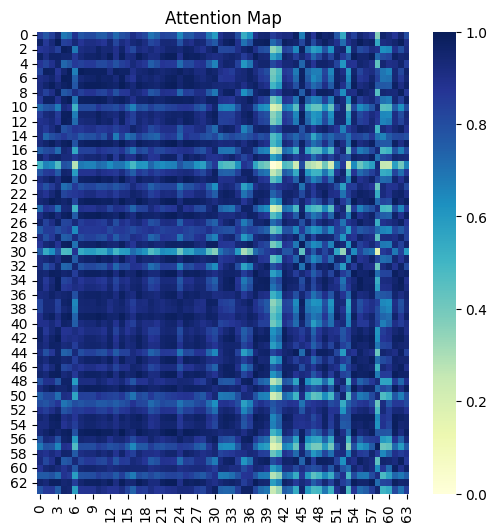

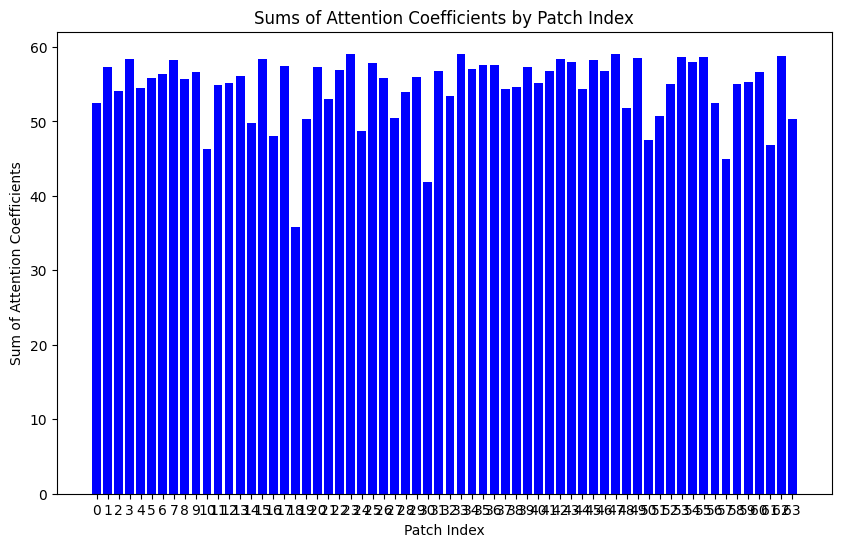

tensor([2, 1, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 0, 0, 1, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 29%|██▉       | 29/100 [14:15:14<35:25:55, 1796.55s/it]

torch.Size([240, 64, 16])
Row sums: [52.12803  57.400707 53.846077 58.313194 54.399044 55.58891  56.279243
 58.11666  55.39456  56.246643 45.708622 54.439194 55.063457 55.86013
 49.627403 58.128273 47.514534 57.357307 35.4053   49.918854 57.10727
 52.8927   56.795628 59.001007 48.33124  57.696655 55.82364  50.295013
 53.982544 55.570312 42.043106 56.83644  53.48452  58.945877 57.070248
 57.543354 57.454727 54.31992  54.600574 56.998047 55.22208  56.694443
 58.349228 57.977585 54.282883 58.20632  56.701973 59.022026 51.148525
 58.467102 47.9834   51.114475 55.046684 58.636314 57.894493 58.685387
 52.348175 44.36898  54.847404 55.619926 56.526062 46.730408 58.767494
 49.96197 ]


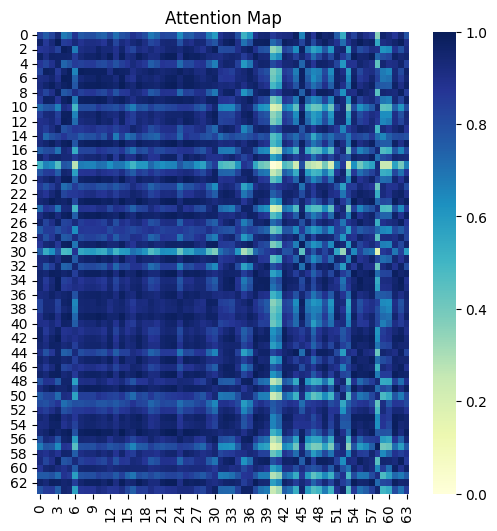

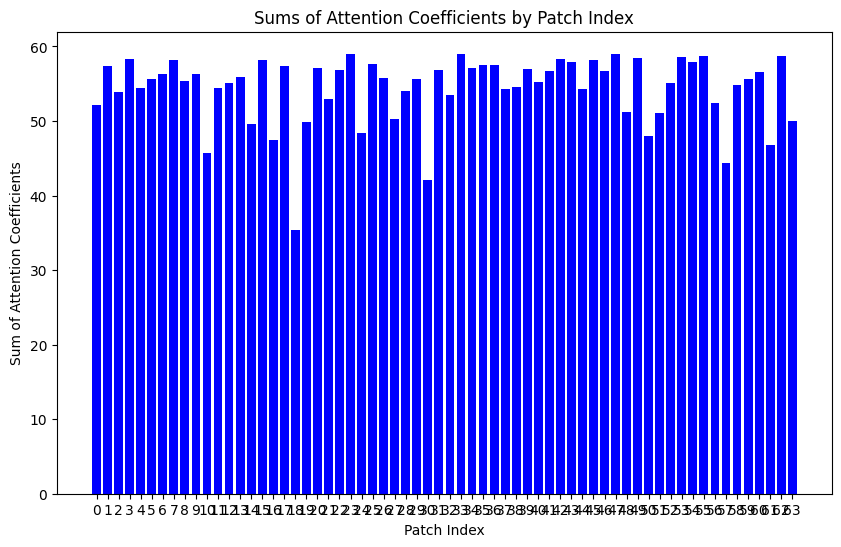

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 30%|███       | 30/100 [14:44:50<34:48:56, 1790.52s/it]

torch.Size([240, 64, 16])
Row sums: [51.77853  57.494392 53.535957 58.1961   54.3826   55.31755  56.15023
 57.960487 55.131847 55.919014 45.164814 53.95208  54.925293 55.679695
 49.36265  57.93213  46.96708  57.336693 35.029694 49.486107 56.915432
 52.847466 56.695496 58.90719  47.89731  57.60018  55.824955 50.193596
 54.08461  55.107872 42.238846 56.871883 53.62413  58.897736 57.1909
 57.47871  57.33508  54.31887  54.655876 56.757427 55.32695  56.641674
 58.32159  57.92075  54.217506 58.158783 56.672104 58.976223 50.585068
 58.443634 48.402687 51.53972  55.104485 58.58484  57.83021  58.756527
 52.230804 43.77571  54.7024   55.948387 56.40014  46.652824 58.6747
 49.667816]


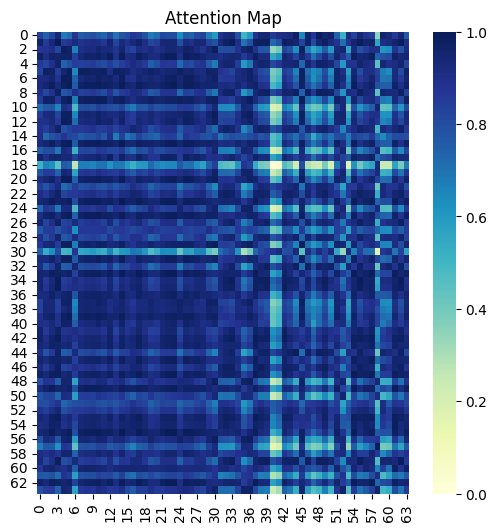

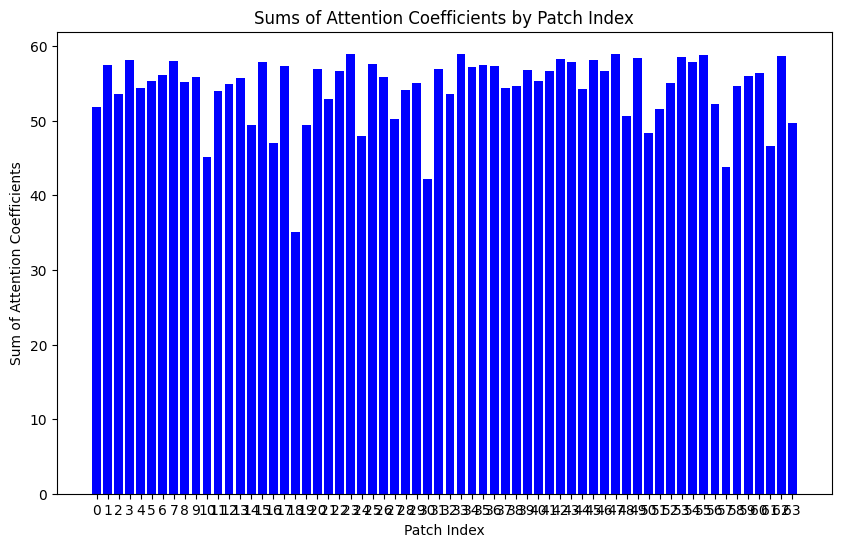

tensor([2, 1, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0,
        0, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 31%|███       | 31/100 [15:14:48<34:21:43, 1792.81s/it]

torch.Size([240, 64, 16])
Row sums: [51.447884 57.586758 53.244907 58.076004 54.371986 55.048607 56.055138
 57.802418 54.88211  55.60574  44.63338  53.449883 54.785587 55.491318
 49.06462  57.74263  46.44757  57.31251  34.672165 49.04986  56.71978
 52.8067   56.593956 58.812973 47.48154  57.52451  55.854088 50.118805
 54.199707 54.63153  42.471107 56.916267 53.803246 58.852394 57.309288
 57.41768  57.232433 54.337494 54.716896 56.543854 55.440094 56.58865
 58.284676 57.861908 54.111713 58.107826 56.62696  58.93254  50.096542
 58.419292 48.802666 51.924557 55.122475 58.528824 57.74311  58.83145
 52.153236 43.206387 54.5867   56.2517   56.25329  46.54861  58.576614
 49.428497]


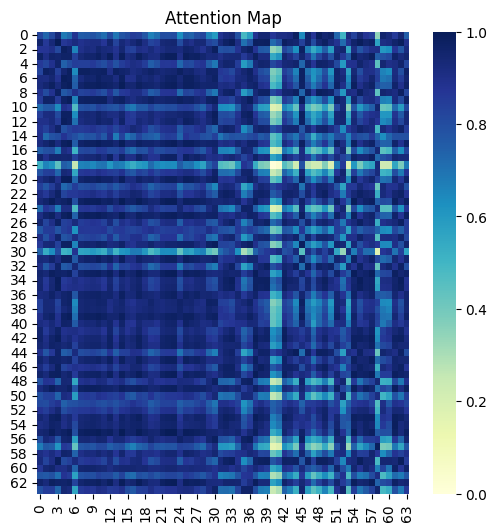

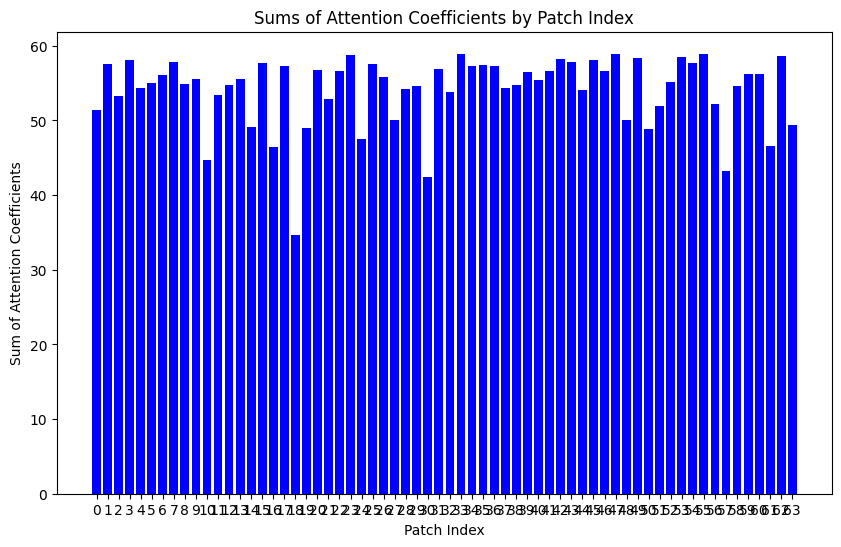

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2, 0, 0,
        2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 32%|███▏      | 32/100 [15:44:53<33:55:51, 1796.35s/it]

torch.Size([240, 64, 16])
Row sums: [51.126907 57.673576 52.99137  57.953423 54.3565   54.783745 55.989075
 57.64187  54.64682  55.313072 44.1192   52.942417 54.66109  55.287907
 48.734642 57.562153 45.960712 57.28103  34.343227 48.614388 56.523388
 52.761887 56.48513  58.71676  47.08756  57.467255 55.878147 50.041935
 54.310444 54.155678 42.71798  56.966194 53.986927 58.806377 57.40006
 57.339294 57.12877  54.35166  54.765224 56.35073  55.555267 56.522095
 58.228523 57.796173 53.96577  58.04771  56.55639  58.886208 49.658123
 58.390823 49.181427 52.259094 55.097916 58.45947  57.62813  58.900066
 52.106426 42.663574 54.500328 56.51867  56.08853  46.417126 58.47351
 49.221413]


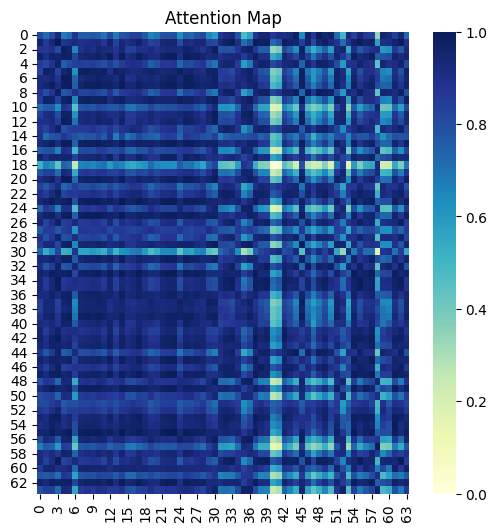

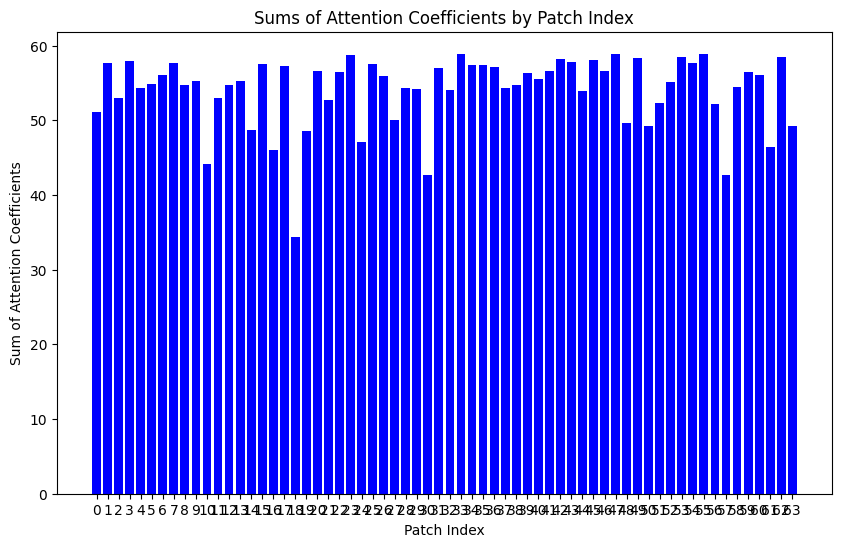

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2, 0, 0,
        2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 33%|███▎      | 33/100 [16:14:49<33:25:54, 1796.34s/it]

torch.Size([240, 64, 16])
Row sums: [50.806267 57.758194 52.77317  57.826195 54.33324  54.51535  55.93994
 57.47381  54.41801  55.032303 43.616905 52.431576 54.554134 55.070606
 48.37474  57.387722 45.4941   57.239326 34.037857 48.17836  56.325195
 52.7099   56.36812  58.61459  46.70378  57.418064 55.88287  49.941032
 54.402916 53.672447 42.965923 57.016052 54.157192 58.755997 57.455734
 57.23841  57.006546 54.342445 54.790222 56.16229  55.665012 56.43814
 58.15302  57.718605 53.785824 57.974125 56.465904 58.83368  49.22602
 58.35562  49.541714 52.54779  55.039135 58.37345  57.483665 58.953545
 52.069065 42.134186 54.434555 56.752354 55.911514 46.251366 58.362373
 49.00954 ]


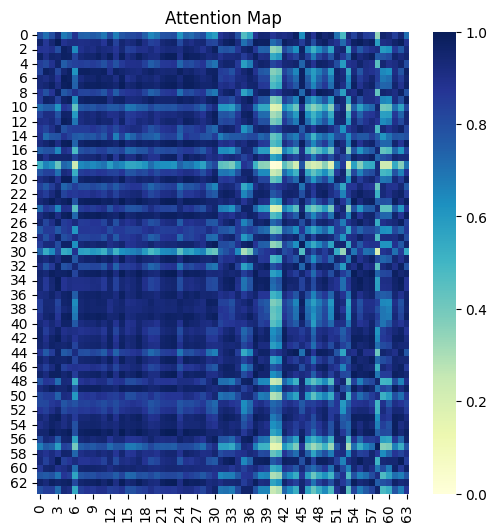

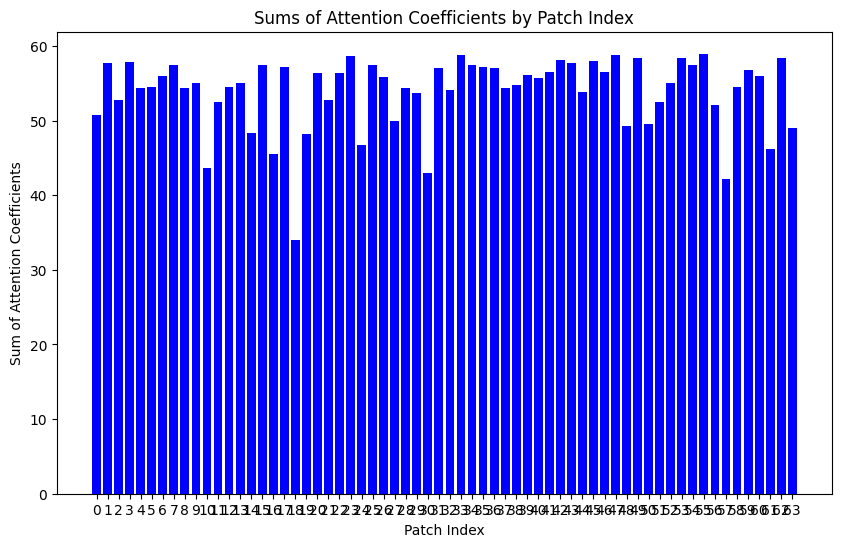

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 2, 1, 2, 1, 1,
        2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0,
        2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 34%|███▍      | 34/100 [16:45:03<33:01:39, 1801.51s/it]

torch.Size([240, 64, 16])
Row sums: [50.477695 57.841385 52.560204 57.68045  54.300766 54.22361  55.885857
 57.28044  54.176506 54.735558 43.10343  51.89566  54.441704 54.83854
 47.981407 57.202026 45.018906 57.174927 33.732285 47.72352  56.106236
 52.64734  56.23841  58.490486 46.300007 57.351555 55.865524 49.800156
 54.464302 53.14049  43.217113 57.051197 54.31381  58.68803  57.478798
 57.112717 56.844624 54.29808  54.78492  55.951687 55.75509  56.33809
 58.05597  57.615036 53.572876 57.87463  56.36714  58.76436  48.759888
 58.302193 49.877678 52.796455 54.952045 58.264847 57.30207  58.976196
 52.006653 41.590263 54.364388 56.95632  55.715405 46.0322   58.223923
 48.757675]


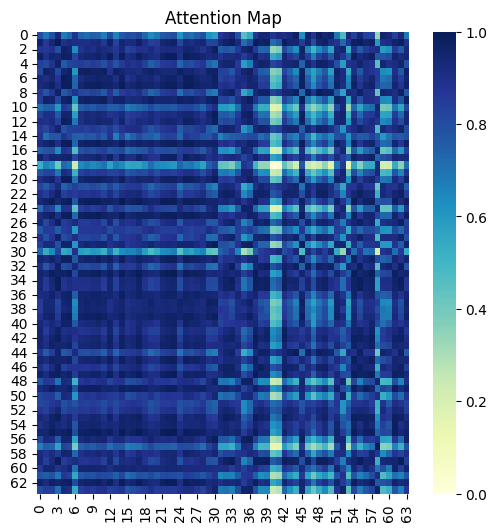

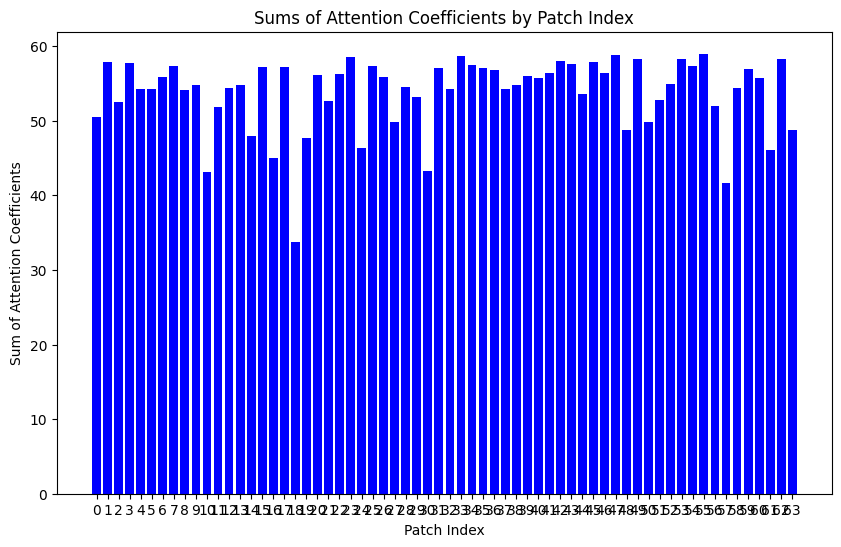

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0,
        2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 35%|███▌      | 35/100 [17:17:41<33:22:32, 1848.50s/it]

torch.Size([240, 64, 16])
Row sums: [50.148224 57.9294   52.322395 57.510685 54.266777 53.901577 55.81598
 57.05221  53.920525 54.405296 42.564545 51.316105 54.2978   54.59801
 47.554398 56.995552 44.5148   57.081512 33.40831  47.236847 55.85183
 52.578617 56.09886  58.33594  45.85395  57.249817 55.845722 49.62414
 54.491737 52.538345 43.48369  57.06491  54.474644 58.597565 57.484734
 56.973312 56.63821  54.228546 54.756798 55.707226 55.821724 56.23741
 57.947456 57.47969  53.332832 57.744743 56.277657 58.67881  48.250767
 58.227135 50.18545  53.014786 54.845703 58.14051  57.086586 58.962723
 51.896027 41.01568  54.26937  57.139336 55.494324 45.74327  58.042282
 48.457924]


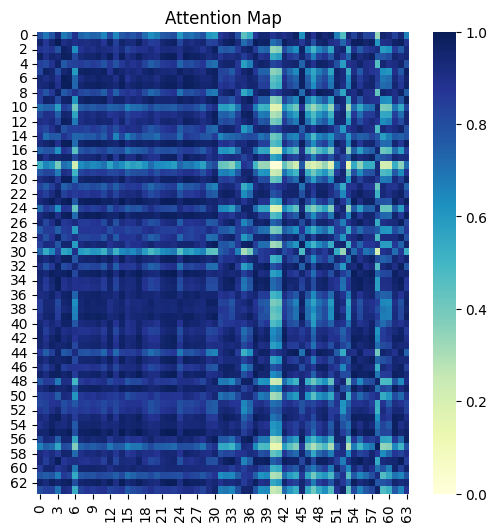

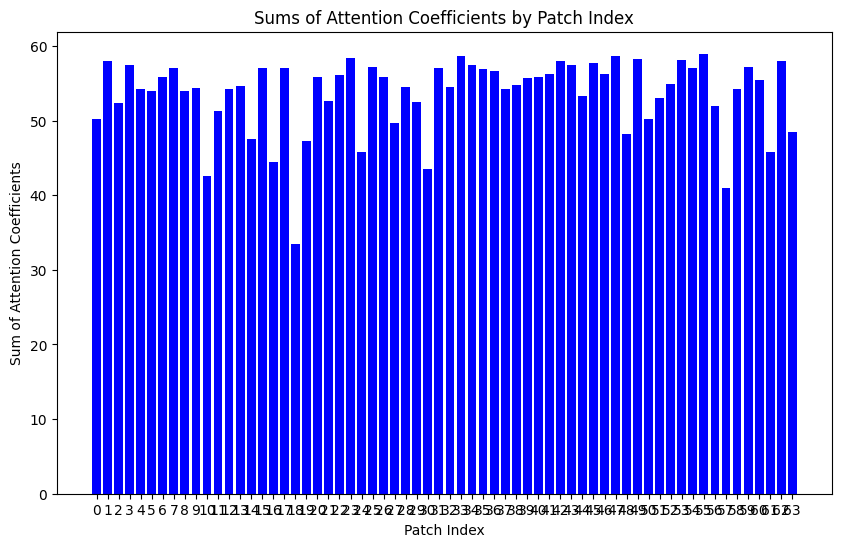

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0,
        2, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 36%|███▌      | 36/100 [17:56:09<35:18:40, 1986.26s/it]

torch.Size([240, 64, 16])
Row sums: [49.84928  58.044205 52.06482  57.344    54.259438 53.58177  55.753654
 56.812813 53.684395 54.061954 42.01986  50.70652  54.12349  54.377304
 47.11178  56.793213 43.997902 56.981056 33.074814 46.73963  55.581345
 52.52854  55.974567 58.17437  45.37816  57.131783 55.87612  49.45349
 54.50862  51.89296  43.78147  57.080055 54.675503 58.510197 57.509666
 56.860382 56.42182  54.175873 54.739677 55.458252 55.89143  56.168407
 57.86312  57.337006 53.098362 57.60807  56.225636 58.60624  47.73572
 58.156635 50.481506 53.22818  54.74505  58.03421  56.872337 58.940384
 51.75429  40.433037 54.162445 57.327873 55.265633 45.396957 57.835075
 48.142544]


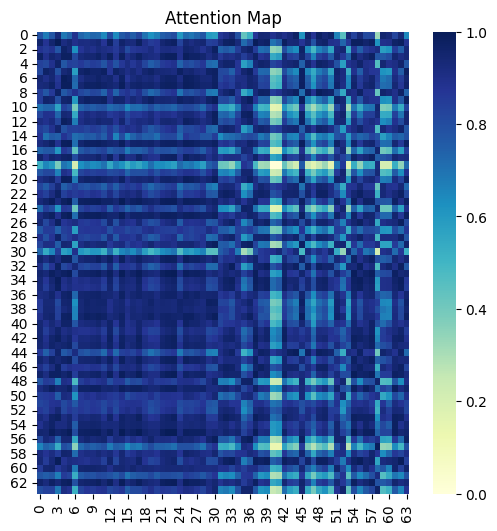

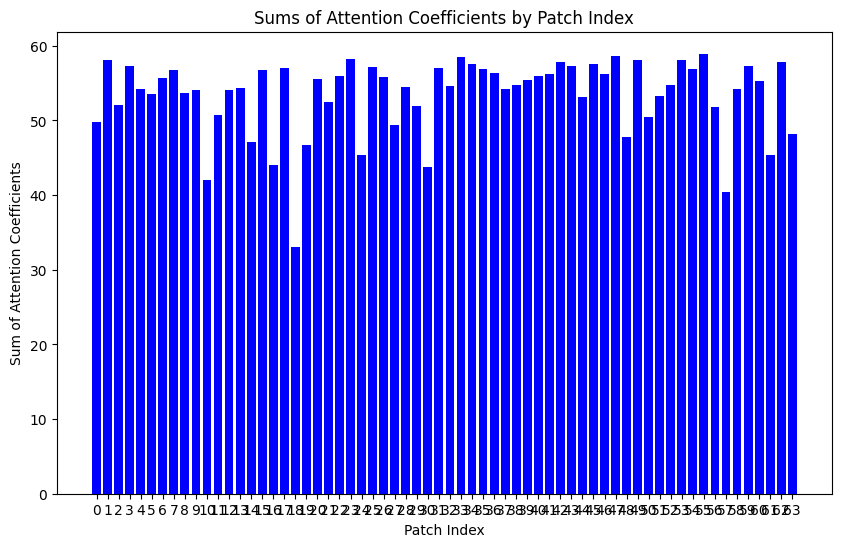

tensor([2, 1, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1,
        2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        2, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 37%|███▋      | 37/100 [18:31:59<35:37:07, 2035.36s/it]

torch.Size([240, 64, 16])
Row sums: [49.585335 58.171688 51.791847 57.185974 54.277195 53.286095 55.702885
 56.567352 53.475697 53.71169  41.475037 50.068047 53.914154 54.175735
 46.652054 56.60207  43.47679  56.873985 32.736633 46.237793 55.295265
 52.49627  55.86178  58.00898  44.875572 57.002163 55.96592  49.30783
 54.51808  51.209595 44.09812  57.097626 54.914024 58.427105 57.552227
 56.780342 56.214245 54.149544 54.7364   55.21794  55.96787  56.12297
 57.801247 57.187164 52.875084 57.46127  56.20309  58.54425  47.243446
 58.092575 50.759834 53.432037 54.6446   57.94574  56.666496 58.914215
 51.591324 39.84871  54.047348 57.514717 55.02522  44.99848  57.600845
 47.829556]


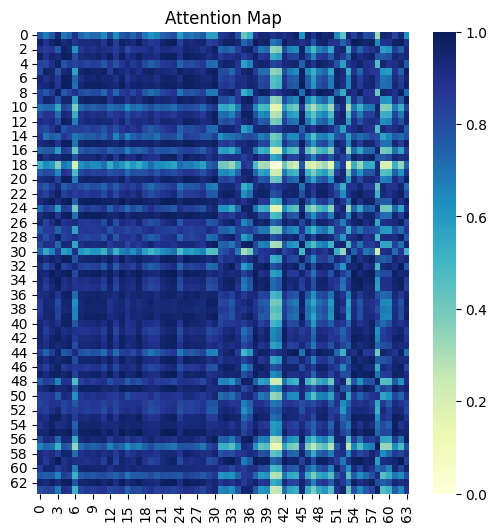

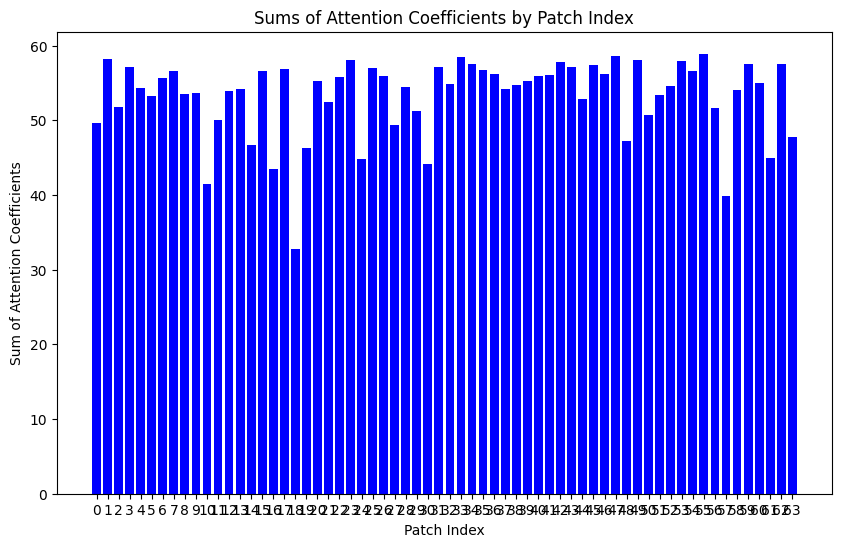

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1,
        2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 0, 0, 0,
        2, 2, 0, 2, 0, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 38%|███▊      | 38/100 [19:04:55<34:44:49, 2017.56s/it]

torch.Size([240, 64, 16])
Row sums: [49.376003 58.297867 51.547096 57.04951  54.32551  53.050835 55.67756
 56.33413  53.309242 53.381546 40.972733 49.431526 53.696354 53.9984
 46.203415 56.440247 42.993866 56.77308  32.452454 45.76452  55.008415
 52.493736 55.767254 57.854042 44.386276 56.880478 56.10682  49.218304
 54.537548 50.516457 44.45242  57.12682  55.187218 58.35457  57.607586
 56.730656 56.039146 54.15958  54.75395  55.01221  56.061974 56.09446
 57.756638 57.038536 52.67401  57.306976 56.203056 58.492485 46.83503
 58.041946 51.034935 53.632656 54.549305 57.871494 56.473194 58.893826
 51.444824 39.30886  53.95417  57.693047 54.787235 44.58921  57.35252
 47.56475 ]


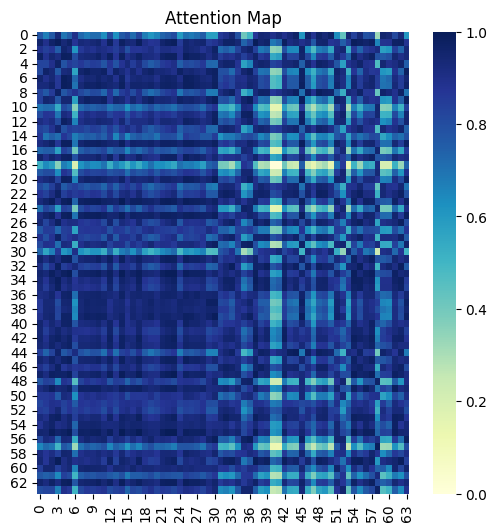

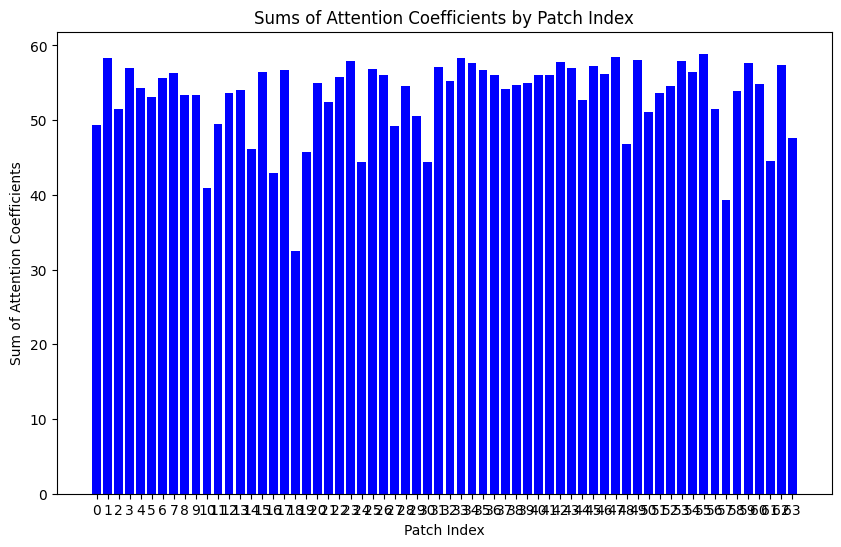

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1,
        2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0,
        2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 39%|███▉      | 39/100 [19:35:56<33:23:30, 1970.66s/it]

torch.Size([240, 64, 16])
Row sums: [49.18465  58.38809  51.34005  56.920116 54.371887 52.858685 55.65917
 56.106174 53.15863  53.065178 40.481567 48.785378 53.47019  53.812073
 45.736168 56.296883 42.52102  56.66938  32.175083 45.29364  54.70991
 52.489174 55.670956 57.704224 43.891815 56.762573 56.251984 49.15169
 54.54866  49.810783 44.79521  57.15069  55.45377  58.279602 57.64518
 56.673485 55.876637 54.174225 54.763565 54.832817 56.153385 56.048786
 57.701805 56.877773 52.461353 57.12684  56.18752  58.43421  46.50431
 57.98963  51.279778 53.800377 54.431587 57.78368  56.265476 58.868294
 51.31055  38.78229  53.88035  57.83306  54.543243 44.14611  57.102524
 47.334167]


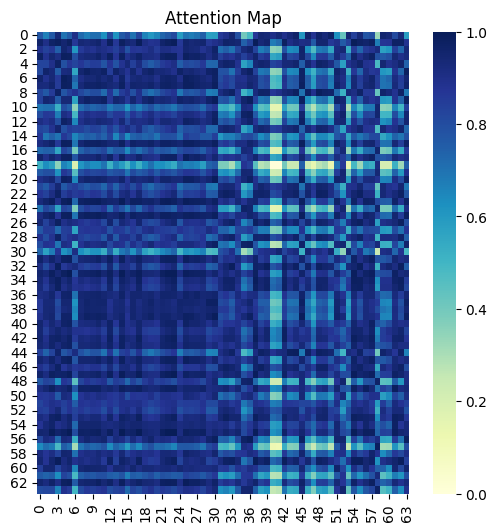

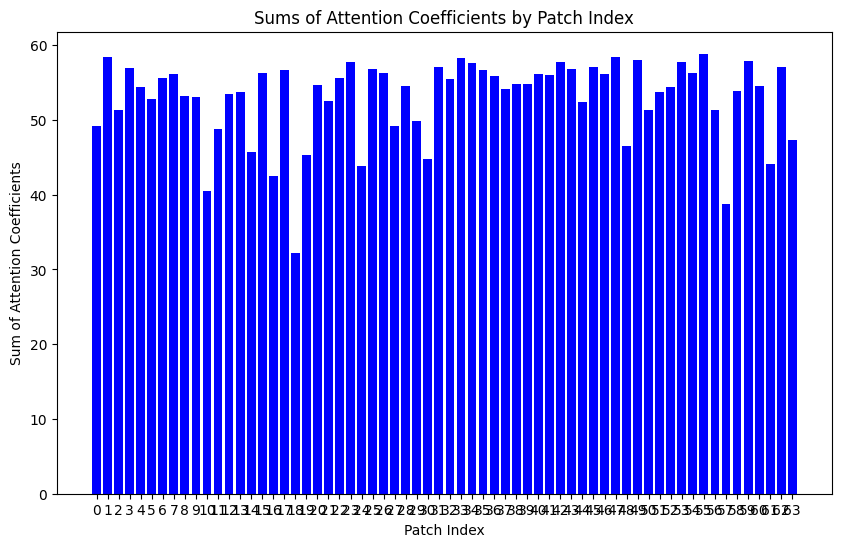

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0,
        2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 40%|████      | 40/100 [20:05:49<31:57:32, 1917.54s/it]

torch.Size([240, 64, 16])
Row sums: [48.99097  58.427635 51.18266  56.78794  54.40057  52.694954 55.639465
 55.883076 53.010277 52.764    40.002155 48.13979  53.250088 53.60222
 45.247406 56.166737 42.05607  56.56375  31.90109  44.825096 54.40515
 52.468628 55.565006 57.557266 43.40107  56.64862  56.371193 49.085785
 54.543488 49.112183 45.110817 57.161728 55.689568 58.198128 57.65027
 56.586864 55.70559  54.17363  54.752068 54.674446 56.23266  55.972733
 57.625595 56.702507 52.22211  56.915527 56.137672 58.36534  46.23877
 57.92982  51.492172 53.92669  54.281483 57.668617 56.031387 58.83251
 51.191147 38.270447 53.827717 57.923447 54.30623  43.671036 56.87629
 47.13266 ]


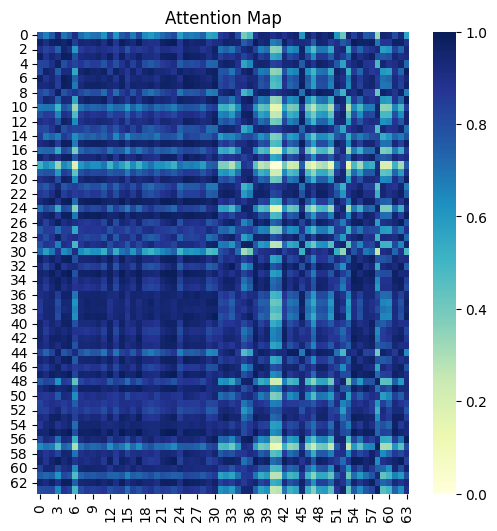

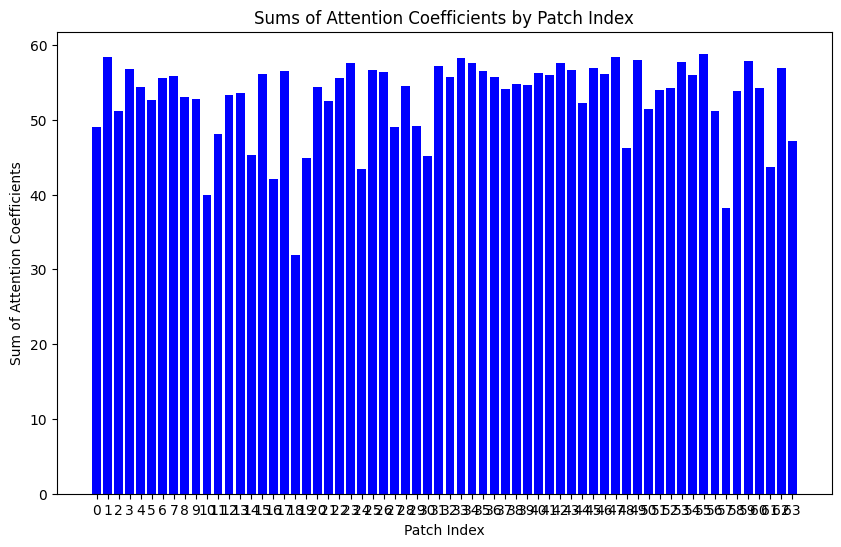

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1,
        2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 0, 0,
        2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 41%|████      | 41/100 [20:36:01<30:54:13, 1885.65s/it]

torch.Size([240, 64, 16])
Row sums: [48.79223  58.423843 51.07399  56.64815  54.413303 52.554157 55.616882
 55.66555  52.862244 52.47713  39.544426 47.507668 53.045803 53.37335
 44.750114 56.04767  41.60311  56.459366 31.641125 44.36848  54.102665
 52.434826 55.451035 57.409496 42.923615 56.53709  56.45912  49.01133
 54.522156 48.43096  45.406544 57.15971  55.892845 58.11153  57.625755
 56.47036  55.51232  54.15262  54.720394 54.528652 56.297348 55.87094
 57.53156  56.514206 51.96051  56.67565  56.057804 58.288578 46.019405
 57.86405  51.68107  54.018387 54.104206 57.526436 55.773808 58.786713
 51.083836 37.781746 53.793434 57.97032  54.095043 43.174774 56.67643
 46.954174]


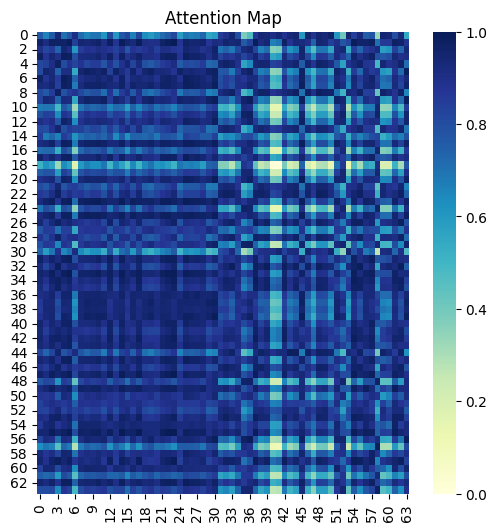

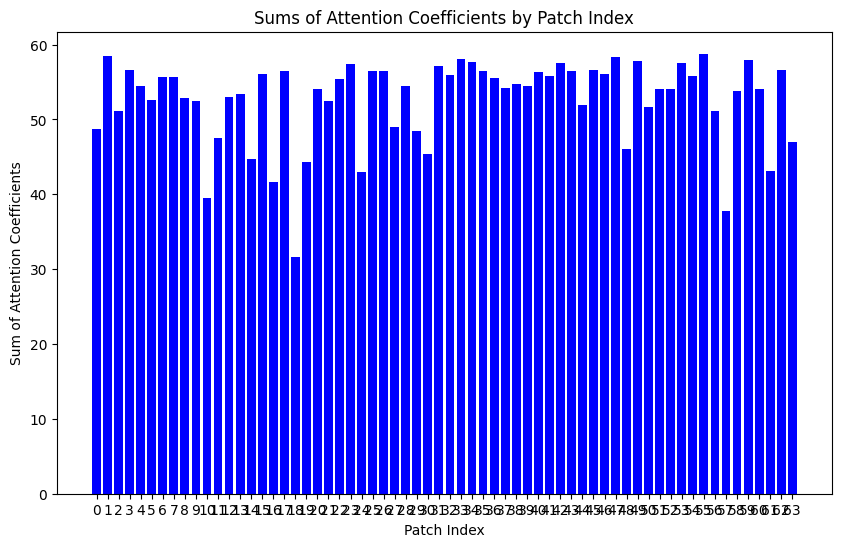

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1,
        2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 0, 0,
        2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 42%|████▏     | 42/100 [21:06:07<29:59:49, 1861.88s/it]

torch.Size([240, 64, 16])
Row sums: [48.568695 58.357338 50.96739  56.46604  54.38992  52.410915 55.557327
 55.418217 52.688164 52.164154 39.079792 46.853233 52.81725  53.108814
 44.228333 55.90296  41.127686 56.321815 31.371445 43.895836 53.764317
 52.36785  55.30414  57.221004 42.41986  56.38547  56.4992   48.898594
 54.45363  47.717365 45.666756 57.113068 56.045956 57.987072 57.550453
 56.303978 55.25966  54.086792 54.644203 54.347336 56.313374 55.725677
 57.39732  56.276443 51.65896  56.3745   55.933544 58.172012 45.797623
 57.76198  51.82004  54.05484  53.878654 57.33147  55.475548 58.69811
 50.941315 37.28407  53.73003  57.953846 53.883415 42.63134  56.453674
 46.759125]


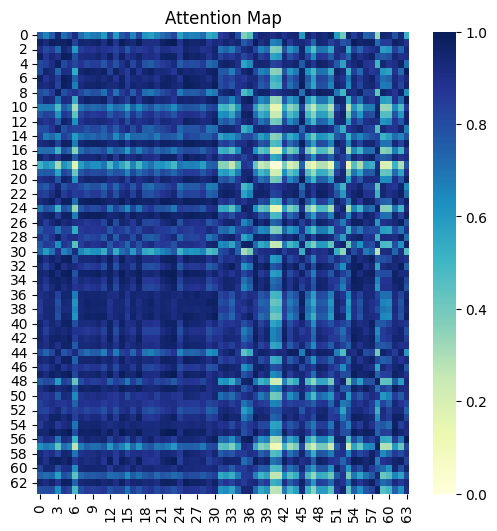

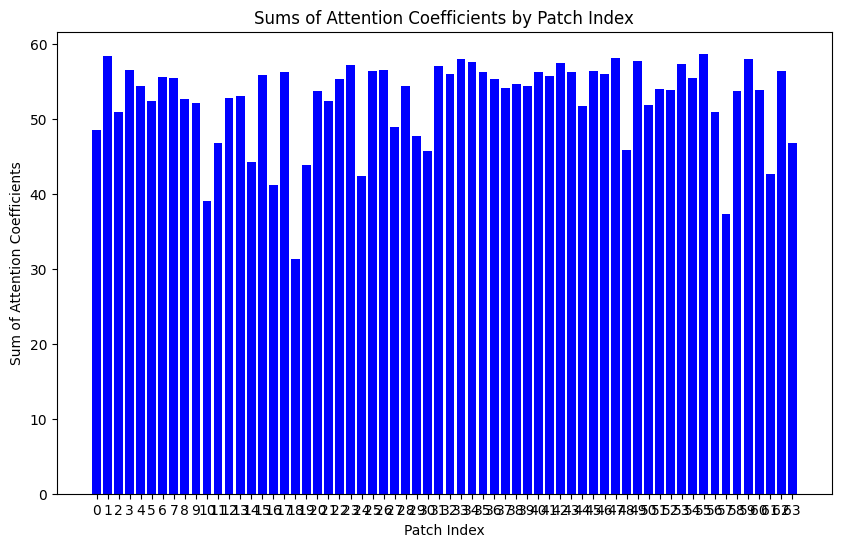

tensor([2, 1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1,
        2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 2,
        0, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 1, 0,
        0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 0,
        0, 1, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2,
        1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1,
        0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0])
tensor([0., 1., 2., 1., 1., 2., 0., 2., 1., 2., 2., 0., 1., 2., 0., 1., 0., 0.,
        1., 2., 1., 2., 1., 2., 0., 0., 2., 1., 0., 1., 0., 0., 2., 2., 0., 1.,
        0., 1., 0., 0., 2., 2., 1., 2.,

 43%|████▎     | 43/100 [21:36:24<29:16:01, 1848.45s/it]

torch.Size([240, 64, 16])


In [18]:
for iepoch in tqdm(range(100)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

In [16]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:
# 학습 후 모델 파라미터 저장 경로
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_1.pth"

In [28]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [29]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

In [30]:
# # Training the model
# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
#     X_tensor = torch.tensor(X_train)
#     predictions = model(X_tensor.float()).squeeze(1)
    
#     label = torch.tensor(y_train)
#     for i in range(len(label)):
#         label[i] = 0 if label[i] == 1 else 1
    
#     loss = criterion(predictions, label.float())
#     acc = binary_accuracy(predictions, label)
#     print(f'Accuracy: {acc}')
#     print(f'Loss: {loss}')
    
#     loss.backward()
#     optimizer.step()
#     print(f"Complete {iepoch} th")

# # Save the model parameters
# torch.save(model.state_dict(), model_save_path)
# print("Model parameters saved.")

Row sums: [54.11699  56.878517 43.35569  56.913185 55.968674 35.168243 54.307762
 48.510445 55.78875  51.240906 52.733814 49.403328 57.427116 51.244587
 57.29963  54.930862 51.178837 52.273533 53.392807 55.21904  49.06929
 53.656677 56.861076 53.735203 36.109394 57.28287  54.76024  54.20981
 56.906754 47.749794 55.34877  53.009857 55.21425  53.614975 55.701614
 54.482384 41.28666  51.640495 37.764496 55.664036 56.97918  57.06447
 51.871452 54.688656 44.649097 54.94396  55.760544 57.082935 57.028877
 50.91393  54.085045 55.48645  56.92231  55.1949   57.25741  56.991203
 46.40087  52.99317  55.702488 55.967457 48.267536 49.696747 31.638039
 53.93479 ]


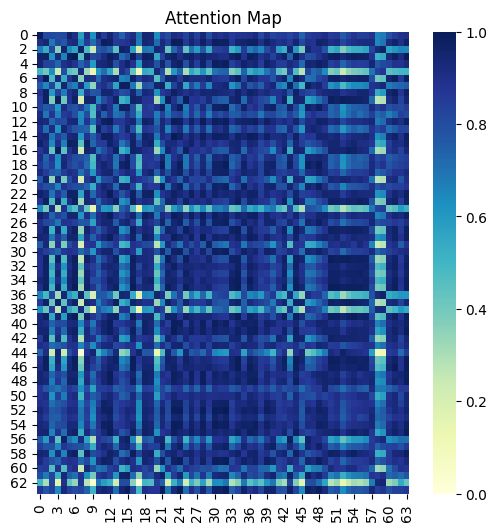

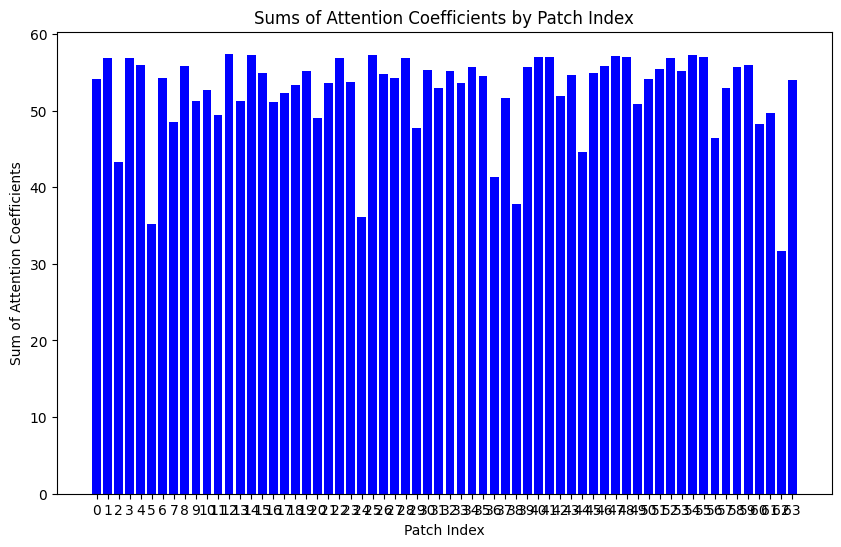


Accuracy: 0.8999999761581421

Loss: 68.84530639648438

AUROC: 0.9625

Precision: 0.9

Recall: 0.9

F1 Score: 0.9

AUPRC: 0.9554093648962576



/tmp/ipykernel_308884/3021993959.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2


In [31]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test)
predictions = attention_model(X_tensor.float()).squeeze(1)
label = torch.tensor(y_test)

# Reverse the labels (if needed)
for i in range(len(label)):
    if label[i] == 1:
        label[i] = 0
    else:
        label[i] = 1

# Calculate loss and accuracy
loss = criterion(predictions, label.float())
acc = binary_accuracy(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Calculate AUROC
auroc = roc_auc_score(labels_np, preds_np)

# Binarize predictions for precision, recall, and F1 calculation
binary_preds = np.where(preds_np > 0.5, 1, 0)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, binary_preds, average='binary')

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(labels_np, preds_np)

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision: {precision}\n')
print(f'Recall: {recall}\n')
print(f'F1 Score: {f1}\n')
print(f'AUPRC: {auprc}\n')


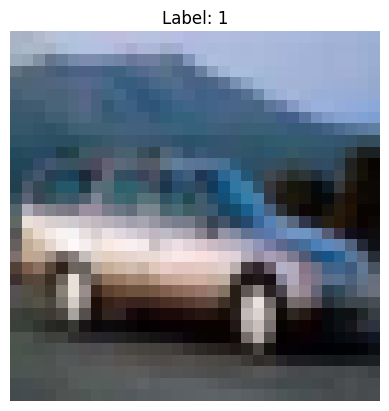

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[4]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[4][0]}')
plt.axis('off')
plt.show()


In [30]:
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
single = np.array([split_into_non_overlapping_patches(image_gray)])

In [31]:
single

array([[[179.062, 177.062, 184.66 , ...,  98.915, 100.083,  93.169],
        [194.023, 192.468, 194.006, ...,  95.287,  95.238,  94.928],
        [193.463, 192.762, 195.039, ...,  91.069,  98.792, 102.526],
        ...,
        [ 57.854,  44.854,  49.082, ...,  91.961,  87.548,  84.124],
        [ 28.869,  28.755,  26.858, ...,  78.124,  78.548,  75.146],
        [ 23.445,  26.146,  28.146, ...,  78.146,  74.146,  76.146]]])

In [32]:
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

In [33]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [34]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=1, bias=True)
)

Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


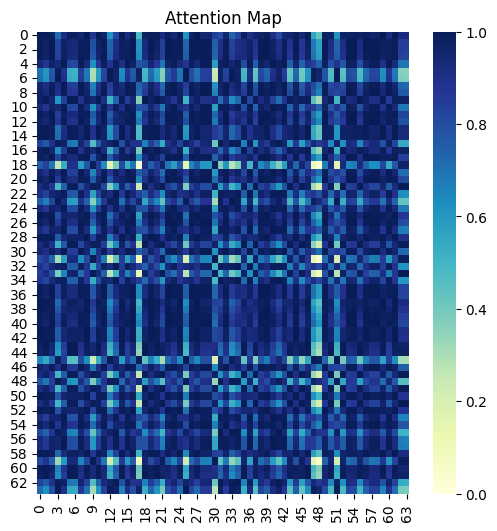

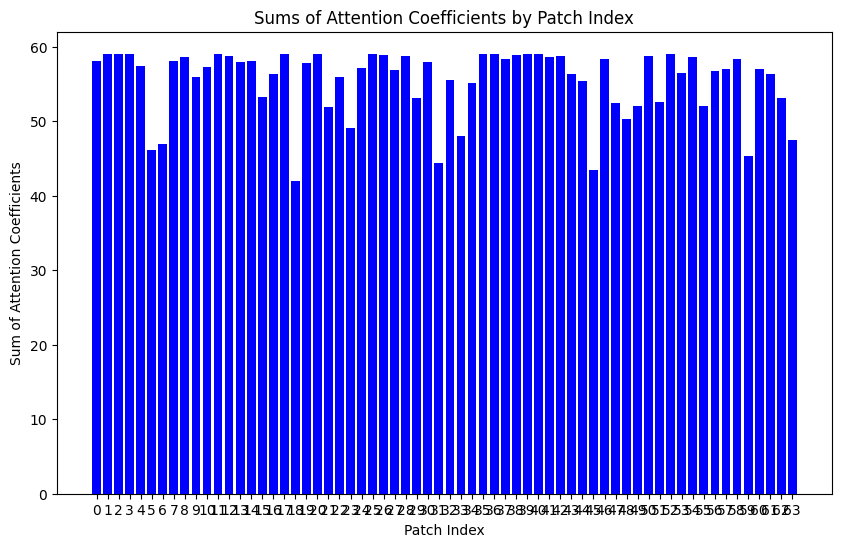

Predicted class for the sample: 1.0
Row sums: [58.063984 59.032066 59.03582  59.017338 57.32975  46.169643 46.861065
 57.99359  58.530388 55.853123 57.24405  59.015244 58.757797 57.89521
 58.031208 53.21495  56.294098 59.03276  41.93651  57.794792 58.947304
 51.86485  55.909496 49.107193 57.081688 58.942497 58.872932 56.888847
 58.687542 53.02982  57.938908 44.345905 55.55957  48.011303 55.104053
 59.01985  59.016228 58.261063 58.81405  59.035725 58.967293 58.558296
 58.699913 56.319786 55.409805 43.420235 58.356987 52.373383 50.236298
 52.02114  58.777344 52.491394 58.941856 56.457733 58.637802 52.067383
 56.77289  56.96529  58.363358 45.35786  57.029922 56.30916  53.03
 47.428307]


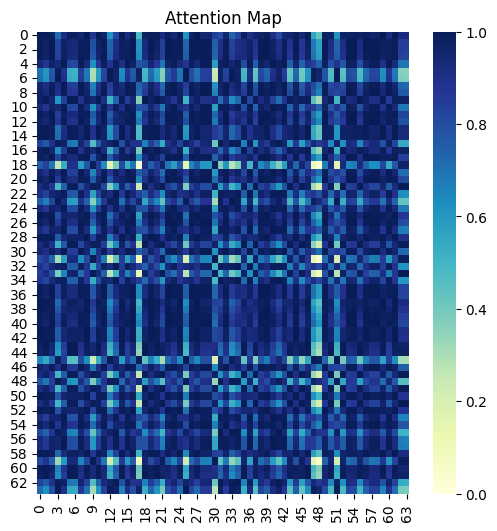

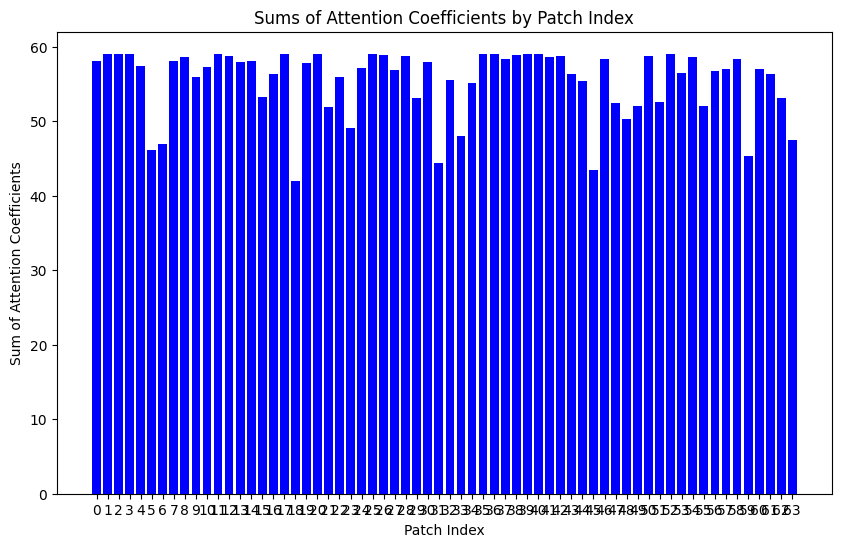

Extracted attention values: tensor([[[0.9977, 0.9988, 0.9877,  ..., 0.9987, 0.9493, 0.9467],
         [0.9968, 0.9808, 1.0000,  ..., 0.9952, 0.8950, 0.8914],
         [0.9960, 0.9791, 1.0000,  ..., 0.9943, 0.8912, 0.8875],
         ...,
         [0.9846, 0.9982, 0.9654,  ..., 0.9875, 0.9773, 0.9755],
         [0.8865, 0.8317, 0.9225,  ..., 0.8786, 0.6781, 0.6730],
         [0.8057, 0.7415, 0.8510,  ..., 0.7962, 0.5775, 0.5724]]])


In [35]:
# Make a prediction for the single sample
# Get the attention values for a single sample
with torch.no_grad():
    prediction = attention_model(single_sample).squeeze()
    predicted_class = (torch.round(prediction)).item()
    print(f"Predicted class for the sample: {predicted_class}")

    _ = attention_model(single_sample)  # Forward pass to calculate attention
    attention_values = attention_model.attention_values  # Extracted attention values
    print(f"Extracted attention values: {attention_values}")

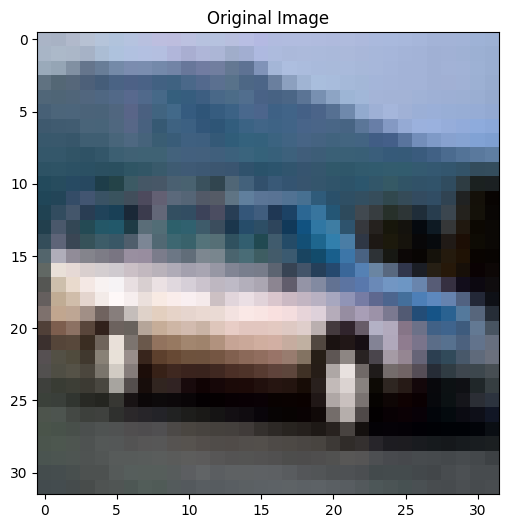

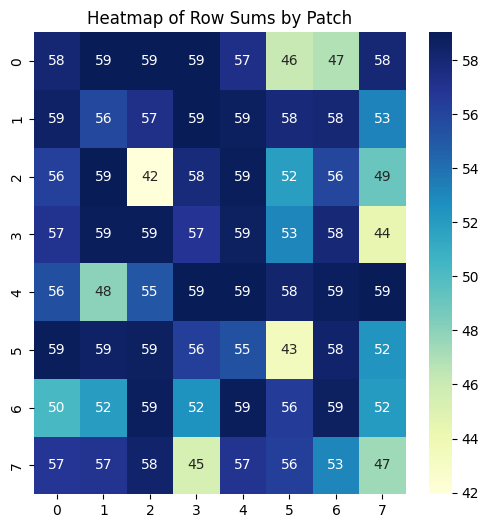

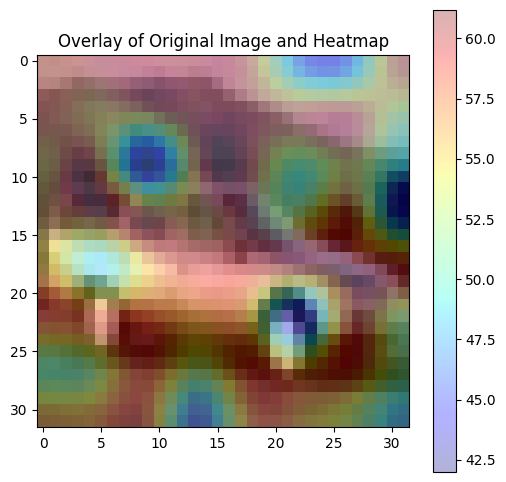

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, row_sums, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    # 2. Create the heatmap using the row sums
    heatmap_values = np.array(row_sums).reshape(patch_shape)

    plt.figure(figsize=(6, 6))
    sns.heatmap(heatmap_values, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Heatmap of Row Sums by Patch")
    plt.show()

    # 3. Resize the heatmap to match the sample size
    from scipy.ndimage import zoom
    resized_heatmap = zoom(heatmap_values, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(resized_heatmap, cmap='jet', alpha=0.3, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image

# Example row sums based on output
row_sums =[58.063984, 59.032066, 59.03582, 59.017338, 57.32975, 46.169643, 46.861065, 57.99359, 58.530388, 55.853123, 57.24405, 59.015244, 58.757797, 57.89521, 58.031208, 53.21495, 56.294098, 59.03276, 41.93651, 57.794792, 58.947304, 51.86485, 55.909496, 49.107193, 57.081688, 58.942497, 58.872932, 56.888847, 58.687542, 53.02982, 57.938908, 44.345905, 55.55957, 48.011303, 55.104053, 59.01985, 59.016228, 58.261063, 58.81405, 59.035725, 58.967293, 58.558296, 58.699913, 56.319786, 55.409805, 43.420235, 58.356987, 52.373383, 50.236298, 52.02114, 58.777344, 52.491394, 58.941856, 56.457733, 58.637802, 52.067383, 56.77289, 56.96529, 58.363358, 45.35786, 57.029922, 56.30916, 53.03, 47.428307]



# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, row_sums, patch_shape=(8, 8))


-----------------------------------------